In [1]:
'''!pip install folium geopandas scikit-learn
!pip install requests
!pip install pyproj
!pip install requests
!pip install hdbscan'''

'!pip install folium geopandas scikit-learn\n!pip install requests\n!pip install pyproj\n!pip install requests\n!pip install hdbscan'

In [1]:
import pandas as pd
import numpy as np
import folium
from folium.plugins import MarkerCluster
import webbrowser
from pyproj import Transformer
import hdbscan
import matplotlib.pyplot as plt
import seaborn as sns
import requests
import re


In [2]:
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm

# 한글글 폰트 설정
plt.rcParams['font.family'] = 'Malgun Gothic'
plt.rcParams['axes.unicode_minus'] = False 

In [3]:
bus_Sta_row= pd.read_excel(r'C:/Users/leehy/OneDrive/바탕 화면/study/통계공모전/data/서울시버스정류소위치정보(20250513).xlsx')
park_row = pd.read_csv(r'C:/Users/leehy/OneDrive/바탕 화면/study/통계공모전/data/서울시 주요 공원현황.csv', encoding='euc-kr')
work_row = pd.read_csv(r'C:/Users/leehy/OneDrive/바탕 화면/study/통계공모전/data/한국장애인고용공단_장애인 표준사업장 현황_20241231.csv', encoding='euc-kr')
school_row = pd.read_csv(r'C:/Users/leehy/OneDrive/바탕 화면/study/통계공모전/data/서울시 특수학교 기본정보.csv',encoding='euc-kr')
organ_row = pd.read_csv(r'C:/Users/leehy/OneDrive/바탕 화면/study/통계공모전/data/서울시 사회복지시설(장애인지역사회재활시설) 목록.csv', encoding='euc-kr')
hos_row = pd.read_csv(r'C:/Users/leehy/OneDrive/바탕 화면/study/통계공모전/data/서울시 병원 인허가 정보.csv', encoding='euc-kr')
lib_row = pd.read_csv(r'C:/Users/leehy/OneDrive/바탕 화면/study/통계공모전/data/서울시 장애인 도서관 현황정보.csv', encoding='euc-kr')
apt_row = pd.read_csv(r'C:/Users/leehy/OneDrive/바탕 화면/study/통계공모전/data/서울시 공동주택 아파트 정보.csv', encoding='euc-kr')
alpha_row = pd.read_csv(r'C:/Users/leehy/OneDrive/바탕 화면/study/통계공모전/data/한국장애인고용공단_장애물 없는 생활환경(Barrier Free) 인증 시설 정보_20241231.csv', encoding='cp949')

low_bus_row = pd.read_excel(r"C:/Users/leehy/OneDrive/바탕 화면/study/통계공모전/data/서울시 저상버스 도입 노선 및 노선별 보유율(25.4.25).xlsx")
bus_id_row = pd.read_excel(r"C:/Users/leehy/OneDrive/바탕 화면/study/통계공모전/data/서울시버스노선ID정보(20250513).xlsx")
best_bus_station = pd.read_excel(r"C:/Users/leehy/OneDrive/바탕 화면/study/통계공모전/data/서울시버스노선별정류소정보(20250513).xlsx")

# 주소정제 함수

clean_address: 도로명 주소 정제  
clean_address_v2: 지번 주소 정제  
kakao_geocode(address, rest_api_key): 카카오api이용, 정제주소 데이터로 경도/위도 데이터 추출  
api_key = "1858ee6befeab68591dcd9d1bb5fa99a"

In [4]:
# 주소 정제 함수
def clean_address(addr):
    if pd.isnull(addr):
        return None
    addr = re.sub(r'[^\w가-힣0-9\s\-.,()]', '', str(addr))
    addr = re.sub(r'\s+', ' ', addr).strip()
    return addr

#지번/도로명 주소 혼합.

def clean_address_v2(addr):
    import re
    addr = str(addr)
    addr = re.sub(r'\([^)]*\)', '', addr)

    # 도로명주소
    addr = re.sub(r'(\d+[가-힣a-zA-Z\s]*로\d*(길)?\d*-?\d*)[^\s]*', r'\1', addr)

    # 도로명주소, 지번주소처리리
    if '로' in addr and '길' in addr:
        addr = addr.split('길')[0] + '길'

    # 특수문자, 공백 정리
    addr = re.sub(r'[^\w가-힣0-9\s\-.,]', '', addr)
    addr = re.sub(r'\s+', ' ', addr).strip()

    return addr

# 카카오 API 함수
def kakao_geocode(address, rest_api_key):
    url = 'https://dapi.kakao.com/v2/local/search/address.json'
    headers = {"Authorization": f"KakaoAK {rest_api_key}"}
    params = {"query": address}
    res = requests.get(url, headers=headers, params=params).json()

    try:
        lat = res['documents'][0]['y']
        lon = res['documents'][0]['x']
        time.sleep(0.4) 
        return float(lat), float(lon)
    except:
        if ',' in address:
            trimmed_address = address.split(',')[0]
            params["query"] = trimmed_address
            retry_res = requests.get(url, headers=headers, params=params).json()
            try:
                lat = retry_res['documents'][0]['y']
                lon = retry_res['documents'][0]['x']
                return float(lat), float(lon)
            except:
                print(f"[2차 실패] 주소: {address} → {trimmed_address}")
                return None, None
        else:
            print(f"[1차 실패] 주소: {address}")
            return None, None


api_key = "1858ee6befeab68591dcd9d1bb5fa99a"

In [ ]:
import requests
import pandas as pd
import time

def kakao_geocode_with_fallback(address, keyword, rest_api_key):
    url_addr = 'https://dapi.kakao.com/v2/local/search/address.json'
    headers = {"Authorization": f"KakaoAK {rest_api_key}"}
    params = {"query": address}
    
    res = requests.get(url_addr, headers=headers, params=params).json()
    if res.get('documents'):
        lat = res['documents'][0]['y']
        lon = res['documents'][0]['x']
        return float(lat), float(lon), 'address'

    # 2. 주소 실패하면 → 장소명으로 fallback
    url_place = 'https://dapi.kakao.com/v2/local/search/keyword.json'
    params = {"query": keyword}
    
    res_place = requests.get(url_place, headers=headers, params=params).json()
    if res_place.get('documents'):
        lat = res_place['documents'][0]['y']
        lon = res_place['documents'][0]['x']
        return float(lat), float(lon), 'keyword'

    # 3. 둘 다 실패
    return None, None, 'fail'

In [68]:
# 시설명 기준 주소 검색 및 좌표 추출
def extract_coords_from_facility(row, api_key):
    keyword = row['시설명']
    district = row['시군구']
    query = f"서울특별시 {district} {keyword}"
    lat, lon, source = kakao_geocode_with_fallback(query, keyword, api_key)
    return pd.Series([lat, lon, source])



# eda

전처리

1. 버스 정류장 데이터

node_id - drop

In [11]:
bus_Sta_row.head()
bus_Sta_row.head().to_clipboard(index=False)

In [12]:

print(bus_Sta_row.info())
print("")
print(bus_Sta_row.isnull().sum())
print("")
print(bus_Sta_row['정류소타입'].value_counts())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11301 entries, 0 to 11300
Data columns (total 6 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   NODE_ID  11301 non-null  int64  
 1   ARS_ID   11301 non-null  int64  
 2   정류소명     11301 non-null  object 
 3   X좌표      11301 non-null  float64
 4   Y좌표      11301 non-null  float64
 5   정류소타입    11301 non-null  object 
dtypes: float64(2), int64(2), object(2)
memory usage: 529.9+ KB
None

NODE_ID    0
ARS_ID     0
정류소명       0
X좌표        0
Y좌표        0
정류소타입      0
dtype: int64

정류소타입
일반차로     6227
마을버스     4179
중앙차로      407
가로변시간     256
가로변전일     141
가상정류장      91
Name: count, dtype: int64


In [13]:
bus_sta = bus_Sta_row.drop('NODE_ID', axis=1)
bus_sta.tail()

,ARS_ID,정류소명,X좌표,Y좌표,정류소타입
11296,25995,천호우성아파트,127.139339,37.550386,일반차로
11297,25996,천호우성아파트,127.140046,37.550643,일반차로
11298,25997,라움포레아파트,127.123596,37.533630,일반차로
11299,25998,성내시장,127.125497,37.536155,일반차로
11300,25999,천호동로데오거리,127.127337,37.540343,일반차로


2. 공원 데이터

연번, 공원명, 지역, 공원 주소, 좌표 4개 제외 모두 드랍    
좌표 null 10개 데이터 - 드랍

GRS80TM 좌표 : 국내 기준 좌표계   
WGS84 좌표계 : 전 세계 기준    
-> WGS84 (위도/경도) 사용. grs80tm 드랍   
-> **lat, lon**으로 칼럼 명 변경(다른 데이터와 통일)


In [14]:
park_row.head().to_clipboard(index=False)


In [15]:
park_row.head()

,연번,공원명,공원개요,면적,개원일,주요시설,주요식물,안내도,오시는길,이용시참고사항,이미지,지역,공원주소,관리부서,전화번호,X좌표(GRS80TM),Y좌표(GRS80TM),X좌표(WGS84),Y좌표(WGS84),바로가기
0,1,남산공원,남산공원은 도심에 위치하여 서울시민에게 맑은 공기를 제공하는 자연휴식처이며 산책 꽃...,2896887㎡ 임 야 : 2454140㎡ 녹지대 및 기타시설 : 442747㎡,1968.9.10,기반시설 : 광장 45950㎡ 도로 108530㎡ 산책로 6.7㎞ (북측:3.7㎞/...,소나무 단풍 아카시아 상수리나무 등 191종 2881870주,http://parks.seoul.go.kr/upload/seditorMulti/2...,명동역(남산케이블카 와룡묘 서울애니메이션센터 방면) 도보 명동역 3번출구 → 퍼시픽...,남산공원 차량통행 금지안내 2005년 5월 1일부터 남산공원에 일반승용차 택시 통행...,http://parks.seoul.go.kr/file/info/view.do?fId...,중구,서울특별시 중구 삼일대로 231(예장동),중부공원여가센터,02-3783-5900,198364.107,450395.554,126.990377,37.550140,http://parks.seoul.go.kr/template/sub/namsan.do
1,2,길동생태공원,길동생태공원은 생물의 서식처를 제공하고 종다양성을 증진시키며 자연생태계의 생물들을 ...,79258.7㎡,1999.5.20,"생태문화센터, 탐방객안내센터, 반딧불이 체험관, 목재데크, 조류관찰대",소나무 보리수 등 64종 31800주 산국 부들 등 138종 192800본,http://parks.seoul.go.kr/template/common/img/p...,지하철: 9호선 중앙보훈병원역 3번출구에서 시내버스 환승 5호선 강동역 4번출구에서...,매주 월요일은 휴관입니다 사전예약 후 입장하실 수 있습니다. 공원을 깨끗하게 이용합...,http://parks.seoul.go.kr/file/info/view.do?fId...,강동구,서울특별시 강동구 천호대로 1291(길동생태공원),동부공원여가센 공원운영과,02-472-2770/ 02-489-2770,213554.120,448852.675,127.154779,37.540394,http://parks.seoul.go.kr/template/sub/gildong.do
2,3,서울대공원,서울대공원은 세계 각국의 야생동물들이 살아 숨 쉬는 서울동물원과 다양한 기후대의 식...,9132690m²,1984.5.1,동물원 식물원 테마가든(장미원 어린이동물원 피크닉장) 치유숲 산림욕장 캠핑장 국립현...,"엘레강스야자, 용설란, 파리지옥, 네펜데스, 장미 등",https://grandpark.seoul.go.kr/conts/contsView/...,지하철 4호선 대공원역 하차(2번 출구) 도보 15분 정도 문의처 02)500-73...,일반사항 공원을 깨끗하게 이용합니다. 대중교통을 이용해 주세요. 기념물 시설물 풀과...,http://parks.seoul.go.kr/file/info/view.do?fId...,과천시,경기도 과천시 대공원광장로 102,서울대공원 전략기획실,02-500-7033,200994.267,437163.981,127.019846,37.426449,http://grandpark.seoul.go.kr/
3,4,서울숲,서울숲은 한강과 중랑천이 만나고 한강-용산-남찬-청계천-서울숲-한강으로 연결되는 서...,480994㎡,2005.6.18,문화예술시설: 바닥분수 거울연못 군마상 야외무대 가족마당무대 생태시설: 꽃사슴방사장...,수 목 : 소나무 섬잣나무 계수나무 외 95종 415795주 식물원 : 선인장 등 ...,http://parks.seoul.go.kr/template/common/img/p...,지하철: 분당선 서울숲역 4번출구에서 도보 약 2분 2호선 뚝섬역 8번출구에서 도보...,지하철 분당선 서울숲역 4번출구 도보로 약2분 2호선 뚝섬역 8번출구 도보로 약 1...,http://parks.seoul.go.kr/file/info/view.do?fId...,성동구,서울특별시 성동구 뚝섬로 273 (성수동1가),동부여가센터 서울숲관리사무소,02-460-2905,203695.432,449290.726,127.041798,37.543072,http://parks.seoul.go.kr/template/sub/seoulfor...
4,5,월드컵공원,월드컵공원은 서울의 서쪽에 위치하여 1978년부터 1993년까지 15년간 서울시민이...,2284085㎡,2002.5.1,평화의 공원 월드컵공원전시관(879㎡) 유니세프광장(2400㎡) 평화광장(5217㎡...,NaN,http://parks.seoul.go.kr/template/common/img/p...,지하철 6호선 월드컵경기장역 하차 → 1번 출구로 나온 후 직진 → 큰길(도로)이 ...,일반사항 공원을 깨끗하게 이용합니다. 대중교통을 이용해 주세요. 기념물 시설물 풀과...,http://parks.seoul.go.kr/file/info/view.do?fId...,마포구,서울특별시 마포구 하늘공원로 84(월드컵공원),서부공원여가센터,02-300-5501,190658.070,451598.831,126.878907,37.571805,http://parks.seoul.go.kr/template/sub/worldcup...


In [16]:
park_row.info()

print(park_row.isnull().sum())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 131 entries, 0 to 130
Data columns (total 20 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   연번            131 non-null    int64  
 1   공원명           130 non-null    object 
 2   공원개요          131 non-null    object 
 3   면적            130 non-null    object 
 4   개원일           124 non-null    object 
 5   주요시설          125 non-null    object 
 6   주요식물          90 non-null     object 
 7   안내도           103 non-null    object 
 8   오시는길          119 non-null    object 
 9   이용시참고사항       121 non-null    object 
 10  이미지           130 non-null    object 
 11  지역            130 non-null    object 
 12  공원주소          131 non-null    object 
 13  관리부서          131 non-null    object 
 14  전화번호          131 non-null    object 
 15  X좌표(GRS80TM)  121 non-null    float64
 16  Y좌표(GRS80TM)  121 non-null    float64
 17  X좌표(WGS84)    130 non-null    float64
 18  Y좌표(WGS84)    130 non-null    

In [17]:
drop_t = ['공원개요','면적','개원일','주요시설','주요식물','안내도','오시는길','이용시참고사항','이미지','관리부서','전화번호','바로가기', 'X좌표(GRS80TM)', 'Y좌표(GRS80TM)']
park = park_row.drop(drop_t, axis = 1)

park = park.dropna()


In [18]:
park.rename(columns={'Y좌표(WGS84)': "lat", 'X좌표(WGS84)': 'lon'}, inplace=True) #칼럼명 변경

In [19]:
park.isnull().sum()
park.head()

,연번,공원명,지역,공원주소,lon,lat
0,1,남산공원,중구,서울특별시 중구 삼일대로 231(예장동),126.990377,37.550140
1,2,길동생태공원,강동구,서울특별시 강동구 천호대로 1291(길동생태공원),127.154779,37.540394
2,3,서울대공원,과천시,경기도 과천시 대공원광장로 102,127.019846,37.426449
3,4,서울숲,성동구,서울특별시 성동구 뚝섬로 273 (성수동1가),127.041798,37.543072
4,5,월드컵공원,마포구,서울특별시 마포구 하늘공원로 84(월드컵공원),126.878907,37.571805


3. 장애인 고용 사업장  
장애인 10명 이상, 상시근로자 중 장애인을 30% 이상 (상시근로자 수에 따라 중증장애인 고용의무 구간별 적용)을 고용한 사업장 정보


관할지사 중 서울**만 남기고 드랍.  
drop = 인증번호, 사업체명, 사업자 등록번호, 인증일자, 전화번호, 업종및주요생산품품, 구분  




In [20]:
work_row.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 797 entries, 0 to 796
Data columns (total 10 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   인증번호        797 non-null    object
 1   사업체명        797 non-null    object
 2   관할지사        797 non-null    object
 3   대표자         797 non-null    object
 4   사업자등록번호     797 non-null    object
 5   소재지         797 non-null    object
 6   인증일자        797 non-null    object
 7   전화번호        747 non-null    object
 8   업종 및 주요생산품  797 non-null    object
 9   구분          797 non-null    object
dtypes: object(10)
memory usage: 62.4+ KB


In [21]:
work_row.head()

,인증번호,사업체명,관할지사,대표자,사업자등록번호,소재지,인증일자,전화번호,업종 및 주요생산품,구분
0,제2013-001호,㈜포스코휴먼스,경북지사,이성록,506-81-69850,경상북도 포항시 남구 동해안로 6213번길 15-1,2013-06-19,054-220-7733,"서비스업(사무지원), 세탁업, 차량관리사업",자회사
1,제2013-003호,㈜오피스메카,서울지역본부,김서진,106-81-80897,"서울특별시 용산구 청파로 77, 6동 1층 23호(원효로3가, 원효전자상가)",2013-06-19,1588-7993,"제조업(사무용품, 홍보판촉용품, 인쇄 디자인 등)",일반
2,제2013-004호,㈜뉴덕흥기업,서울지역본부,백성현,110-81-68835,서울특별시 은평구 응암로 319(응암동),2013-06-19,031-964-0896,세탁업(병원 세탁물),일반
3,제2013-005호,㈜그린주의,서울북부지사,김현미,204-81-97877,"서울특별시 중랑구 신내역로3길 40-36, A동 1층 R106호(신내동, 신내데시앙...",2013-06-19,1544-0725,"제조업(문구류, 카트리지, 인쇄, 판촉기념품)",일반
4,제2013-008호,㈜베어베터,서울북부지사,이진희,101-86-71777,서울특별시 성동구 성수일로4길 25(성수동2가),2013-06-19,02-6267-6919,"제조업, 출판, 도매 및 소매업(인쇄업, 빵, 과자 제조 및 판매, 커피가공업, ...",일반


In [22]:
print(work_row['구분'].value_counts())
print("")
print(work_row['관할지사'].value_counts())


구분
일반      628
자회사     168
컨소시엄      1
Name: count, dtype: int64

관할지사
서울남부지사    68
경기북부지사    67
부산지역본부    46
대구지역본부    46
경기서부지사    44
인천지사      43
경기동부지사    37
서울북부지사    37
전북지사      37
서울지역본부    36
경기지역본부    34
대전지역본부    33
충남지사      29
광주지역본부    28
울산지사      27
경북지사      27
서울동부지사    27
전남지사      27
충북지사      26
경남동부지사    24
제주지사      22
강원지사      18
경남서부지사    14
Name: count, dtype: int64


In [23]:
drop_t = ['인증번호', '대표자','사업자등록번호','인증일자', '전화번호', '업종 및 주요생산품', '구분']
work = work_row[work_row['관할지사'].str.startswith('서울')]
work = work.drop(drop_t, axis = 1)

work.tail()

,사업체명,관할지사,소재지
762,경일기업,서울북부지사,"서울특별시 성북구 보문로29길 119, 5층"
765,디자인ADC,서울동부지사,"서울특별시 강동구 천호대로 1469-1, 201호(상일동)"
766,주식회사 지앤지대양,서울남부지사,"서울특별시 강서구 마곡중앙4로 10, A동 9층 921~923호(마곡동)"
778,온누리산업,서울남부지사,"서울특별시 강서구 마곡중앙4로 18, 비동 8층 802호(마곡동)"
795,한국장애인표준사업장 사회적협동조합,서울동부지사,"서울특별시 송파구 송이로 150, 6층"


In [24]:
work.isnull().sum()

사업체명    0
관할지사    0
소재지     0
dtype: int64

In [25]:
work['정제주소'] = work['소재지'].apply(clean_address)
work[['lat', 'lon']] = work['정제주소'].apply(lambda x: pd.Series(kakao_geocode(x, api_key)))

[2차 실패] 주소: 서울특별시 용산구 청파로 77, 6동 1층 23호(원효로3가, 원효전자상가) → 서울특별시 용산구 청파로 77
[1차 실패] 주소: 서울특별시 은평구 응암로 319(응암동)
[2차 실패] 주소: 서울특별시 중랑구 신내역로3길 40-36, A동 1층 R106호(신내동, 신내데시앙플랙스지식산업센터) → 서울특별시 중랑구 신내역로3길 40-36
[1차 실패] 주소: 서울특별시 성동구 성수일로4길 25(성수동2가)
[2차 실패] 주소: 서울특별시 중구 서애로5길 15(필동3가, 호산나빌딩) → 서울특별시 중구 서애로5길 15(필동3가
[1차 실패] 주소: 서울특별시 용산구 한강대로38길 37(용산동5가)
[1차 실패] 주소: 서울특별시 종로구 북촌로 71 (가회동)
[2차 실패] 주소: 서울특별시 중랑구 신내역로3길 40-36, B동 OB103호 → 서울특별시 중랑구 신내역로3길 40-36
[1차 실패] 주소: 서울특별시 서초구 반포대로 22 서초평화빌딩 14층
[2차 실패] 주소: 서울특별시 금천구 가산디지털1로 119, 비동 212호(가산동,SK트윈테크타워) → 서울특별시 금천구 가산디지털1로 119
[2차 실패] 주소: 서울특별시 금천구 벚꽃로 254, 1207호 (가산동, 월드메르디앙벤쳐센터) → 서울특별시 금천구 벚꽃로 254
[2차 실패] 주소: 서울특별시 금천구 범안로 15길 73, 3층 → 서울특별시 금천구 범안로 15길 73
[2차 실패] 주소: 서울특별시 영등포구 선유로 70, 3층 301호(문래동3가, 우리벤처타운2) → 서울특별시 영등포구 선유로 70
[1차 실패] 주소: 서울특별시 영등포구 영등포로5길 19 동아프라임밸리 901903
[1차 실패] 주소: 서울특별시 금천구 두산로 9길 28
[1차 실패] 주소: 서울특별시 중구 동호로14길 7 BS빌딩 5층(신당동)
[2차 실패] 주소: 서울특별시 영등포구 당산로 41길 11, 1403호(당산동4가, 당산 에스케이브이1 센터) → 서울특별시 영등포구 당산로 41길 11
[2

In [26]:
work.tail()

,사업체명,관할지사,소재지,정제주소,lat,lon
762,경일기업,서울북부지사,"서울특별시 성북구 보문로29길 119, 5층","서울특별시 성북구 보문로29길 119, 5층",None,None
765,디자인ADC,서울동부지사,"서울특별시 강동구 천호대로 1469-1, 201호(상일동)","서울특별시 강동구 천호대로 1469-1, 201호(상일동)",None,None
766,주식회사 지앤지대양,서울남부지사,"서울특별시 강서구 마곡중앙4로 10, A동 9층 921~923호(마곡동)","서울특별시 강서구 마곡중앙4로 10, A동 9층 921923호(마곡동)",None,None
778,온누리산업,서울남부지사,"서울특별시 강서구 마곡중앙4로 18, 비동 8층 802호(마곡동)","서울특별시 강서구 마곡중앙4로 18, 비동 8층 802호(마곡동)",None,None
795,한국장애인표준사업장 사회적협동조합,서울동부지사,"서울특별시 송파구 송이로 150, 6층","서울특별시 송파구 송이로 150, 6층",None,None


In [27]:
work.isnull().sum()

사업체명      0
관할지사      0
소재지       0
정제주소      0
lat     168
lon     168
dtype: int64

주소 정제 실패 4개데이터 삭제

In [28]:
work = work.dropna(subset=['lat'])

4. 특수학교 데이터

drop = '학교종류명', '설립구분', '표준학교코드', '영문학교명', '도로명우편번호', '도로명상세주소', '전화번호','홈페이지주소','팩스번호','남녀공학구분명' '고등학교구분명','산업체특별학급존재여부','고등학교일반실업구분명','특수목적고등학교계열명','입시전후기구분명','주야구분명','설립일자', '개교기념일',	'시도교육청코드',	'시도교육청명','소재지명',	'적재일시'

In [29]:
school_row.head()

,학교종류명,설립구분,표준학교코드,학교명,영문학교명,관할조직명,도로명우편번호,도로명주소,도로명상세주소,전화번호,...,고등학교일반실업구분명,특수목적고등학교계열명,입시전후기구분명,주야구분명,설립일자,개교기념일,시도교육청코드,시도교육청명,소재지명,적재일시
0,특수학교,공립,7011485,서울서진학교,Seoul Seojin,서울특별시교육청,7527,서울특별시 강서구 양천로55길 22,(가양동),02-6981-9000,...,NaN,NaN,전기,주간,20200301,20200420,B10,서울특별시교육청,서울특별시,20230627
1,특수학교,공립,7011484,서울도솔학교,SeoulDosolSchool,서울특별시교육청,1301,서울특별시 도봉구 평화로15번길 9-26,(도봉동/ 서울도솔학교),02-955-0523,...,NaN,NaN,전기,주간,20190901,20190901,B10,서울특별시교육청,서울특별시,20230627
2,특수학교,공립,7011483,서울나래학교,Seoul Narae School,서울특별시교육청,6793,서울특별시 서초구 염곡안1길 25,(염곡동/ 서울나래학교),02-2058-0190,...,NaN,NaN,전기,주간,20190901,20190901,B10,서울특별시교육청,서울특별시,20230627
3,특수학교,사립,7011468,서울새롬학교,Seoul Saerom School,서울특별시교육청,8709,서울특별시 관악구 보라매로 44,/ 서울새롬학교 (봉천동/ 삼육외래센터),02-840-3535,...,해당없음,NaN,전기,주간,19690728,19690728,B10,서울특별시교육청,서울특별시,20230627
4,특수학교,사립,7011462,서울효정학교,Seoul Hyojeong,서울특별시교육청,1109,서울특별시 강북구 삼양로63길 33,(미아동),02-981-2022,...,NaN,NaN,전기,주간,20170901,20170901,B10,서울특별시교육청,서울특별시,20230627


In [30]:
school_row.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32 entries, 0 to 31
Data columns (total 25 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   학교종류명        32 non-null     object 
 1   설립구분         32 non-null     object 
 2   표준학교코드       32 non-null     int64  
 3   학교명          32 non-null     object 
 4   영문학교명        32 non-null     object 
 5   관할조직명        32 non-null     object 
 6   도로명우편번호      32 non-null     int64  
 7   도로명주소        32 non-null     object 
 8   도로명상세주소      32 non-null     object 
 9   전화번호         32 non-null     object 
 10  홈페이지주소       32 non-null     object 
 11  팩스번호         32 non-null     object 
 12  남녀공학구분명      32 non-null     object 
 13  고등학교구분명      0 non-null      float64
 14  산업체특별학급존재여부  32 non-null     object 
 15  고등학교일반실업구분명  27 non-null     object 
 16  특수목적고등학교계열명  0 non-null      float64
 17  입시전후기구분명     32 non-null     object 
 18  주야구분명        32 non-null     object 
 19  설립일자      

In [31]:
school_row.columns.tolist()

['학교종류명',
 '설립구분',
 '표준학교코드',
 '학교명',
 '영문학교명',
 '관할조직명',
 '도로명우편번호',
 '도로명주소',
 '도로명상세주소',
 '전화번호',
 '홈페이지주소',
 '팩스번호',
 '남녀공학구분명',
 '고등학교구분명',
 '산업체특별학급존재여부',
 '고등학교일반실업구분명',
 '특수목적고등학교계열명',
 '입시전후기구분명',
 '주야구분명',
 '설립일자',
 '개교기념일',
 '시도교육청코드',
 '시도교육청명',
 '소재지명',
 '적재일시']

In [32]:
print(school_row['학교종류명'].value_counts())
print("")

print(school_row['주야구분명'].value_counts())
print("")
print(school_row['남녀공학구분명'].value_counts())
print("")

print(school_row['고등학교구분명'].value_counts())
print("")
print(school_row['산업체특별학급존재여부'].value_counts())
print("")

print(school_row['고등학교일반실업구분명'].value_counts())
print("")
print(school_row['특수목적고등학교계열명'].value_counts())
print("")
print(school_row['입시전후기구분명'].value_counts())
print("")
print(school_row['주야구분명'].value_counts())
print("")

print(school_row['시도교육청명'].value_counts())
print("")
print(school_row['관할조직명'].value_counts())
print("")



학교종류명
특수학교    32
Name: count, dtype: int64

주야구분명
주간    32
Name: count, dtype: int64

남녀공학구분명
남여공학    32
Name: count, dtype: int64

Series([], Name: count, dtype: int64)

산업체특별학급존재여부
N    32
Name: count, dtype: int64

고등학교일반실업구분명
해당없음    26
일반계      1
Name: count, dtype: int64

Series([], Name: count, dtype: int64)

입시전후기구분명
전기    32
Name: count, dtype: int64

주야구분명
주간    32
Name: count, dtype: int64

시도교육청명
서울특별시교육청    32
Name: count, dtype: int64

관할조직명
서울특별시교육청    29
교육부          3
Name: count, dtype: int64



In [33]:
drop_t = ['학교종류명', '설립구분', '표준학교코드', '영문학교명', '도로명우편번호', '도로명상세주소', '전화번호','홈페이지주소',
        '팩스번호','남녀공학구분명', '고등학교구분명','산업체특별학급존재여부','고등학교일반실업구분명','특수목적고등학교계열명',
        '입시전후기구분명','주야구분명','설립일자', '개교기념일',	'시도교육청코드',	'시도교육청명','소재지명',	'적재일시']

school = school_row.drop(drop_t, axis=1)
school.tail()

,학교명,관할조직명,도로명주소
27,서울정문학교,서울특별시교육청,서울특별시 관악구 난향3길 31
28,서울정진학교,서울특별시교육청,서울특별시 구로구 부일로9길 158
29,한국우진학교,교육부,서울특별시 마포구 월드컵북로38길 21
30,서울농학교,교육부,서울특별시 종로구 필운대로 103
31,서울맹학교,교육부,서울특별시 종로구 필운대로 97


In [47]:
school[['lat', 'lon']] = school['도로명주소'].apply(lambda x: pd.Series(kakao_geocode(x, api_key)))

In [48]:
school['정제주소'] = school['도로명주소'].apply(clean_address)
school[['lat', 'lon']] = school['정제주소'].apply(lambda x: pd.Series(kakao_geocode(x, api_key)))

In [50]:
school.head()

,학교명,관할조직명,도로명주소,lat,lon,정제주소
0,서울서진학교,서울특별시교육청,서울특별시 강서구 양천로55길 22,37.565477,126.850622,서울특별시 강서구 양천로55길 22
1,서울도솔학교,서울특별시교육청,서울특별시 도봉구 평화로15번길 9-26,37.694840,127.042477,서울특별시 도봉구 평화로15번길 9-26
2,서울나래학교,서울특별시교육청,서울특별시 서초구 염곡안1길 25,37.464025,127.051498,서울특별시 서초구 염곡안1길 25
3,서울새롬학교,서울특별시교육청,서울특별시 관악구 보라매로 44,37.493168,126.927372,서울특별시 관악구 보라매로 44
4,서울효정학교,서울특별시교육청,서울특별시 강북구 삼양로63길 33,37.627130,127.016222,서울특별시 강북구 삼양로63길 33


In [51]:
school[['lat', 'lon']] = school.apply(
    lambda row: pd.Series(
        kakao_geocode_with_fallback(row['정제주소'], row['학교명'], api_key)
    ),
    axis=1
)


ValueError: Columns must be same length as key

In [52]:
school.isnull().sum()

학교명      0
관할조직명    0
도로명주소    0
lat      0
lon      0
정제주소     0
dtype: int64

In [53]:
school.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32 entries, 0 to 31
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   학교명     32 non-null     object 
 1   관할조직명   32 non-null     object 
 2   도로명주소   32 non-null     object 
 3   lat     32 non-null     float64
 4   lon     32 non-null     float64
 5   정제주소    32 non-null     object 
dtypes: float64(2), object(4)
memory usage: 1.6+ KB


In [54]:
school.head()


,학교명,관할조직명,도로명주소,lat,lon,정제주소
0,서울서진학교,서울특별시교육청,서울특별시 강서구 양천로55길 22,37.565477,126.850622,서울특별시 강서구 양천로55길 22
1,서울도솔학교,서울특별시교육청,서울특별시 도봉구 평화로15번길 9-26,37.694840,127.042477,서울특별시 도봉구 평화로15번길 9-26
2,서울나래학교,서울특별시교육청,서울특별시 서초구 염곡안1길 25,37.464025,127.051498,서울특별시 서초구 염곡안1길 25
3,서울새롬학교,서울특별시교육청,서울특별시 관악구 보라매로 44,37.493168,126.927372,서울특별시 관악구 보라매로 44
4,서울효정학교,서울특별시교육청,서울특별시 강북구 삼양로63길 33,37.627130,127.016222,서울특별시 강북구 삼양로63길 33


5. 장애인시설 데이터

drop = 시설종류상세명, 시군구코드,자치구(시)구분, 전화번호, 우편번호   
도로명주소/지번주소 혼합되어있음

In [55]:
organ_row.head()

,시설명,시설코드,시설종류명(시설유형),시설종류상세명(시설종류),자치구(시)구분,시군구코드,시군구명,시설주소,전화번호,우편번호
0,방이복지관,A5039,(장애인복지시설) 장애인복지관,장애인지역사회재활시설,자치구,1171000000,송파구,"서울특별시 송파구 백제고분로37길 4, 5층 (석촌동)",NaN,NaN
1,서울시각장애인복지관,A5105,(장애인복지시설) 장애인복지관,장애인지역사회재활시설,자치구,1171000000,송파구,서울특별시 송파구 삼학사로19길 27 (삼전동),NaN,NaN
2,서울시립발달장애인복지관,A5108,(장애인복지시설) 장애인복지관,장애인지역사회재활시설,자치구,1159000000,동작구,서울특별시 동작구 여의대방로20나길 33 (신대방동),NaN,NaN
3,청음복지관,A5237,(장애인복지시설) 장애인복지관,장애인지역사회재활시설,자치구,1168000000,강남구,서울특별시 강남구 봉은사로50길 6 (역삼동),NaN,NaN
4,마포장애인종합복지관,A5241,(장애인복지시설) 장애인복지관,장애인지역사회재활시설,자치구,1144000000,마포구,"서울특별시 마포구 성산로4길 35 (성산동, 마포장애인종합복지관)",NaN,NaN


In [56]:
organ_row.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 277 entries, 0 to 276
Data columns (total 10 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   시설명            277 non-null    object 
 1   시설코드           277 non-null    object 
 2   시설종류명(시설유형)    277 non-null    object 
 3   시설종류상세명(시설종류)  277 non-null    object 
 4   자치구(시)구분       277 non-null    object 
 5   시군구코드          277 non-null    int64  
 6   시군구명           277 non-null    object 
 7   시설주소           277 non-null    object 
 8   전화번호           0 non-null      float64
 9   우편번호           0 non-null      float64
dtypes: float64(2), int64(1), object(7)
memory usage: 21.8+ KB


In [57]:
organ_row['시설종류명(시설유형)'].value_counts()

시설종류명(시설유형)
(장애인복지시설) 장애인주간보호시설          143
(장애인복지시설) 장애인복지관              58
(장애인복지시설) 장애인재활치료시설           32
(장애인복지시설) 수어(수화)통역센터          28
(장애인복지시설) 장애인체육시설              8
(장애인복지시설) 점자도서관                3
(장애인복지시설) 점자도서 및 녹음서 출판시설      2
(장애인복지시설) 장애인자립생활지원센터          1
(장애인복지시설) 장애인수련시설              1
(장애인복지시설) 장애인생활이동지원센터          1
Name: count, dtype: int64

In [58]:
organ_row['시설종류상세명(시설종류)'].value_counts()

시설종류상세명(시설종류)
장애인지역사회재활시설    277
Name: count, dtype: int64

In [59]:
organ_row['자치구(시)구분'].value_counts()

자치구(시)구분
자치구    277
Name: count, dtype: int64

In [60]:
drop_t = ['시설종류상세명(시설종류)', '시군구코드','자치구(시)구분', '전화번호', '우편번호']
organ = organ_row.drop(drop_t, axis=1)
organ['시설주소'].tail(10)

267                서울특별시 강동구 아리수로 427, 503호 (강일동, 중앙프라자)
268                        서울특별시 마포구 대흥로24길 50 (염리동, 2층)
269                    서울특별시 은평구 은평로3길 10 (역촌동, 은평교회 1층)
270              서울특별시 성동구 왕십리로24나길 20, 6,7층 (도선동, 창성빌딩)
271                서울특별시 노원구 공릉로58길 112301호 (하계동, 순흥빌라트)
272            서울특별시 노원구 상계로23다길 13-8107호 (상계동, 노원 아이파크)
273    서울특별시 마포구 숭문길 14마포구 염리동 14-11일대(염리3구역 사회복지시설용지...
274          서울특별시 마포구 백범로31길 19지역편의시설 1층 (공덕동, 공덕 크로시티)
275              서울특별시 광진구 동일로 357아이맘인지행동발달센터 (중곡동)(중곡동)
276                                  서울특별시 강남구 수서동 741번지
Name: 시설주소, dtype: object

In [61]:
organ['정제주소'] = organ['시설주소'].apply(clean_address_v2)
organ[['lat', 'lon']] =organ['정제주소'].apply(lambda x: pd.Series(kakao_geocode(x, api_key)))


[1차 실패] 주소: 129번지 15호
[1차 실패] 주소: 서울특별시 송파구 올림픽로 474
[1차 실패] 주소: 서울특별시 중구 수표로 69 번지
[1차 실패] 주소: 서울특별시 마포구 월드컵로 마포장애인복지회관
[1차 실패] 주소: 서울특별시 강남구 개포동 12-48
[1차 실패] 주소: 서울특별시 동대문구 용두동 255번지 69호
[1차 실패] 주소: 서울특별시 마포구 숭문길 14마포구 염리동 14-11일대


In [62]:
# 전체 277개중 7개, 약 2.5%는 적은 양 이므로 드랍.
# 주소 자체의 오류 가능성이 높음.

organ[organ['lat'].isna()][['시설명','시설주소','정제주소']]

,시설명,시설주소,정제주소
16,영광 시각장애인 모바일 점자도서관,129번지 15호,129번지 15호
101,송파시각장애인축구장,서울특별시 송파구 올림픽로 474 (방이동),서울특별시 송파구 올림픽로 474
158,영락주간보호센터,서울특별시 중구 수표로 69 번지,서울특별시 중구 수표로 69 번지
200,마포구수어통역센터,서울특별시 마포구 월드컵로 마포장애인복지회관,서울특별시 마포구 월드컵로 마포장애인복지회관
219,하상점자도서관,서울특별시 강남구 개포동 12-48,서울특별시 강남구 개포동 12-48
237,구립동대문장애인종합복지관,서울특별시 동대문구 용두동 255번지 69호,서울특별시 동대문구 용두동 255번지 69호
273,염리종합사회복지관 내 주간보호센터,서울특별시 마포구 숭문길 14마포구 염리동 14-11일대(염리3구역 사회복지시설용지...,서울특별시 마포구 숭문길 14마포구 염리동 14-11일대


In [63]:
organ=organ.dropna(subset=['lat'])
organ.head()

,시설명,시설코드,시설종류명(시설유형),시군구명,시설주소,정제주소,lat,lon
0,방이복지관,A5039,(장애인복지시설) 장애인복지관,송파구,"서울특별시 송파구 백제고분로37길 4, 5층 (석촌동)",서울특별시 송파구 백제고분로37길,37.503717,127.103231
1,서울시각장애인복지관,A5105,(장애인복지시설) 장애인복지관,송파구,서울특별시 송파구 삼학사로19길 27 (삼전동),서울특별시 송파구 삼학사로19길,37.506082,127.094896
2,서울시립발달장애인복지관,A5108,(장애인복지시설) 장애인복지관,동작구,서울특별시 동작구 여의대방로20나길 33 (신대방동),서울특별시 동작구 여의대방로20나길,37.492087,126.917852
3,청음복지관,A5237,(장애인복지시설) 장애인복지관,강남구,서울특별시 강남구 봉은사로50길 6 (역삼동),서울특별시 강남구 봉은사로50길,37.508487,127.043450
4,마포장애인종합복지관,A5241,(장애인복지시설) 장애인복지관,마포구,"서울특별시 마포구 성산로4길 35 (성산동, 마포장애인종합복지관)",서울특별시 마포구 성산로4길,37.563392,126.908910


6. 병원 데이터

drop = 병원이름, 지번주소, 도로명 주소, x좌표, v좌표 제외 모두 드랍  
영업 상태 코드 이용해 13, 영업중 제외한 폐업된 병원 드랍  
 
* 중부원점TM(EPSG:5174) 좌표계 -> 위도경도 좌표로 변환 
    - 전체 873개 데이터중 696개 데이터 수행, 남은 86개 값들은 주소값 이용
* 도로명 주소 이용, 위도경도 좌표 추출
* 지번 주소 이용, 위도경도 좌표 추출출


In [64]:
hos_row.head()

,개방자치단체코드,관리번호,인허가일자,인허가취소일자,영업상태코드,영업상태명,상세영업상태코드,상세영업상태명,폐업일자,휴업시작일자,...,진료과목내용명,지정취소일자,완화의료지정형태,완화의료담당부서명,구급차특수,구급차일반,총인원,구조사수,허가병상수,최초지정일자
0,open_autn_org_cd,mng_no,licensing_ymd,licensing_rtrcn_ymd,bizopr_stat_cd,bizopr_stat_nm,dtl_bizopr_stat_cd,dtl_bizopr_stat_nm,clsbiz_ymd,tcbiz_bgng_ymd,...,clnc_sbject_conts_nm,dsgn_rtrcn_ymd,easing_medi_dsgn_stle,easing_medi_chr_dept_nm,amblnc_spcl,amblnc_gnrl,tot_nmpr,strct_psn_cnt,prmsn_sckbd_cnt,frst_dsgn_ymd
1,3140000,PHMA220193140033021200001,20191213,NaN,01,영업/정상,13,영업중,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3140000,PHMA220063140033021200001,20060810,NaN,01,영업/정상,13,영업중,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,3090000,PHMA220163090033021200001,20160629,NaN,01,영업/정상,13,영업중,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,3220000,PHMA220133220033021200009,20131206,NaN,03,폐업,03,폐업,20190228,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [65]:
hos_row.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 873 entries, 0 to 872
Data columns (total 41 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   개방자치단체코드   873 non-null    object
 1   관리번호       873 non-null    object
 2   인허가일자      873 non-null    object
 3   인허가취소일자    1 non-null      object
 4   영업상태코드     873 non-null    object
 5   영업상태명      873 non-null    object
 6   상세영업상태코드   873 non-null    object
 7   상세영업상태명    873 non-null    object
 8   폐업일자       275 non-null    object
 9   휴업시작일자     26 non-null     object
 10  휴업종료일자     26 non-null     object
 11  재개업일자      1 non-null      object
 12  전화번호       837 non-null    object
 13  소재지면적      1 non-null      object
 14  소재지우편번호    298 non-null    object
 15  지번주소       721 non-null    object
 16  도로명주소      783 non-null    object
 17  도로명우편번호    756 non-null    object
 18  사업장명       873 non-null    object
 19  최종수정일자     873 non-null    object
 20  데이터갱신구분    873 non-null    objec

In [66]:
hos_row['상세영업상태코드'].value_counts()

상세영업상태코드
13                    564
03                    294
24                      7
02                      5
15                      2
dtl_bizopr_stat_cd      1
Name: count, dtype: int64

In [67]:
hos_row['상세영업상태명'].value_counts()

상세영업상태명
영업중                   564
폐업                    294
직권폐업                    7
휴업                      5
전출                      2
dtl_bizopr_stat_nm      1
Name: count, dtype: int64

In [68]:
hos_row = hos_row.drop(index=0)

hospital =  hos_row[['관리번호','사업장명','업태구분명','상세영업상태코드','지번주소','도로명주소','좌표정보(X)','좌표정보(Y)']]

hospital['상세영업상태코드'] = hospital['상세영업상태코드'].astype(int)
hospital = hospital[hospital['상세영업상태코드'] == 13]  #영업중인 병원만 남기기기

hospital = hospital.dropna(subset=['지번주소','도로명주소'] , how='all')

hospital.head()


C:\Users\leehy\AppData\Local\Temp\ipykernel_37796\671395936.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  hospital['상세영업상태코드'] = hospital['상세영업상태코드'].astype(int)


,관리번호,사업장명,업태구분명,상세영업상태코드,지번주소,도로명주소,좌표정보(X),좌표정보(Y)
1,PHMA220193140033021200001,서울스마트요양병원,요양병원(일반요양병원),13,서울특별시 양천구 신정동 1268 복합메디컬타운,"서울특별시 양천구 중앙로 181, 복합메디컬타운 3~8층 (신정동)",187181.28483799,445624.366466149
2,PHMA220063140033021200001,목동힘찬병원,병원,13,서울특별시 양천구 목동 404번지 3호,"서울특별시 양천구 신목로 120 (목동, 힘찬병원)",189047.941727937,446975.068504489
3,PHMA220163090033021200001,서울사랑요양병원,요양병원(일반요양병원),13,서울특별시 도봉구 쌍문동 503-8 2~5층,"서울특별시 도봉구 삼양로 574, 2~5층 (쌍문동)",201098.761383515,461327.62658561
8,PHMA220083230034021201554,뉴스타트병원,병원,13,서울특별시 송파구 가락동 159번지 7호 뉴스타트병원,"서울특별시 송파구 송이로 76, 뉴스타트병원 (가락동)",210493.764941542,444103.26092079
9,PHMA220133220033021200003,기쁨정원치과병원,치과병원,13,"서울특별시 강남구 수서동 713번지 수서현대벤처빌 303호,315호","서울특별시 강남구 밤고개로1길 10, 315호 (수서동, 수서현대벤쳐빌)",208937.760652081,442873.588039887


In [69]:
hospital = hospital.drop('상세영업상태코드',axis=1)
hospital.tail()


,관리번호,사업장명,업태구분명,지번주소,도로명주소,좌표정보(X),좌표정보(Y)
867,PHMA219833240033021200002,한국보훈복지의료공단 중앙보훈병원,종합병원,NaN,서울특별시 강동구 진황도로61길 53 (둔촌동),NaN,NaN
869,PHMA219743090033021200001,의료법인한전의료재단 한일병원,종합병원,서울특별시 도봉구 쌍문동 388-1 한일병원,"서울특별시 도봉구 우이천로 308, 한일병원 (쌍문동)",202466.119176743,460394.329853007
870,PHMA219823080033021200002,신일병원,병원,"서울특별시 강북구 수유동 47번지 7호 (47-7,8,9)",서울특별시 강북구 덕릉로 73 (수유동),201857.42791954,459159.097004897
871,PHMA220043080033021200001,햇빛병원,병원,서울특별시 강북구 미아동 67번지 1호,서울특별시 강북구 도봉로 74 (미아동),202598.720031765,457044.055167975
872,PHMA219823080033021200001,의료법인성화의료재단 대한병원,종합병원,서울특별시 강북구 수유동 45번지 7호,"서울특별시 강북구 도봉로 301 (수유동, 대한병원)",201952.090791867,459227.557988451


In [70]:
# 좌표 변환

transformer = Transformer.from_crs("EPSG:5174", "EPSG:4326", always_xy=True)

def convert_coords(x, y):
    lon, lat = transformer.transform(x, y)
    return pd.Series({'lon':lon, 'lat':lat})


hospital[['lon','lat']] = hospital.apply(lambda row:convert_coords(row['좌표정보(X)'],row['좌표정보(Y)']), axis=1)


hospital['정제주소'] = hospital['지번주소'].apply(clean_address_v2)
hospital['정제주소'] = hospital['도로명주소'].apply(clean_address)
if hospital['lat'].isnull().any():
    hospital[['lat', 'lon']] =hospital['정제주소'].apply(lambda x: pd.Series(kakao_geocode(x, api_key)))

hospital.head()

[1차 실패] 주소: 서울특별시 동작구 상도로 146 (상도동)
[2차 실패] 주소: 서울특별시 송파구 마천로15길 6, 인애가요양병원 (오금동) → 서울특별시 송파구 마천로15길 6


,관리번호,사업장명,업태구분명,지번주소,도로명주소,좌표정보(X),좌표정보(Y),lon,lat,정제주소
1,PHMA220193140033021200001,서울스마트요양병원,요양병원(일반요양병원),서울특별시 양천구 신정동 1268 복합메디컬타운,"서울특별시 양천구 중앙로 181, 복합메디컬타운 3~8층 (신정동)",187181.28483799,445624.366466149,126.855685,37.512819,"서울특별시 양천구 중앙로 181, 복합메디컬타운 38층 (신정동)"
2,PHMA220063140033021200001,목동힘찬병원,병원,서울특별시 양천구 목동 404번지 3호,"서울특별시 양천구 신목로 120 (목동, 힘찬병원)",189047.941727937,446975.068504489,126.876847,37.524981,"서울특별시 양천구 신목로 120 (목동, 힘찬병원)"
3,PHMA220163090033021200001,서울사랑요양병원,요양병원(일반요양병원),서울특별시 도봉구 쌍문동 503-8 2~5층,"서울특별시 도봉구 삼양로 574, 2~5층 (쌍문동)",201098.761383515,461327.62658561,127.013171,37.654347,"서울특별시 도봉구 삼양로 574, 25층 (쌍문동)"
8,PHMA220083230034021201554,뉴스타트병원,병원,서울특별시 송파구 가락동 159번지 7호 뉴스타트병원,"서울특별시 송파구 송이로 76, 뉴스타트병원 (가락동)",210493.764941542,444103.26092079,127.119513,37.499098,"서울특별시 송파구 송이로 76, 뉴스타트병원 (가락동)"
9,PHMA220133220033021200003,기쁨정원치과병원,치과병원,"서울특별시 강남구 수서동 713번지 수서현대벤처빌 303호,315호","서울특별시 강남구 밤고개로1길 10, 315호 (수서동, 수서현대벤쳐빌)",208937.760652081,442873.588039887,127.101844,37.488024,"서울특별시 강남구 밤고개로1길 10, 315호 (수서동, 수서현대벤쳐빌)"


In [71]:
hospital.isnull().sum()

관리번호         0
사업장명         0
업태구분명        0
지번주소       133
도로명주소        0
좌표정보(X)     86
좌표정보(Y)     86
lon          2
lat          2
정제주소         0
dtype: int64

총 873개 데이터중 2개 주소 오류, 드랍

In [72]:
hospital = hospital.dropna(subset=['lat', 'lon'])

7. 장애인 도서관(점자도서관)

사용 칼럼: 도서관명, 구명, 주소, 위도, 경도  
위도, 경도 => lat, lon으로 칼럼명 변경  
주소 => 정제주소로 정제  
폐관된 데이터 제거

In [73]:
lib_row

,도서관 일련번호,도서관명,구 코드,구명,주소,전화번호,홈페이지 URL,운영시간,정기 휴관일,도서관 구분,도서관 구분명,위도,경도
0,74,하상시각장애인도서관,8,강남구,서울특별시 강남구 개포로 613 하상장애인복지회관,02-451-6000,http://onsori.or.kr,"평일 : 09:00~18:00, 주말 : 09:00~18:00","일요일, 공휴일",3,장애인도서관,37.492554,127.075132
1,76,한국시각장애인복지재단점자도서관[이동도서관],10,강동구,서울특별시 강동구 구천면로 645 한국시각장애인복지관,02-440-5201,http://www.hsb.or.kr,"평일 : 09:00~18:00, 주말 : 휴관일","토, 일요일 및 법정공휴일",3,장애인도서관,37.551112,127.169246
2,77,한국점자도서관,10,강동구,서울특별시 강동구 상암로4가길 32 암사2동새마을문고,02-3426-7411~4,http://infor.kbll.or.kr,"평일 : 09:00~18:00, 주말 : 휴관일","토, 일요일 및 법정공휴일",3,장애인도서관,37.550734,127.124858
3,71,강서점자도서관,1,강서구,서울특별시 강서구 공항대로 206 801~803호,"02-2661-2278,2291",http://www.ksbl.or.kr/,"평일 : 09:00~18:00, 주말 : 휴관일","토요일, 일요일, 법정공휴일",3,장애인도서관,37.558893,126.830273
4,73,실로암점자도서관,5,관악구,서울특별시 관악구 남부순환로 1717,02-880-0500,http://www.silwel.or.kr,"평일 : 09:00~18:00, 주말 : 휴관일","매주 토,일요일",3,장애인도서관,37.482941,126.941102
5,70,[폐관]서울점자도서관,22,노원구,서울특별시 노원구 동일로 1335,02-935-9696,http://www.kbuwel.or.kr/,"평일 : 09:00~18:00, 주말 : 휴관일",매주 토.일,3,장애인도서관,37.647998,127.062273
6,870,영광시각장애인모바일점자도서관,14,서대문구,"서울특별시 서대문구 세검정로 78-19, 2층",02-393-4568,http://ygculture.com/,"평일 : 24시간운영, 주말 : 24시간운영",없음,3,장애인도서관,37.595187,126.949025
7,2490,IT로 열린도서관,7,서초구,"서울특별시 서초구 방배로 36, 이삭빌딩 301호",02-3471-3434,http://www.itlo.org/,평일 : 09:00~18:00,"토,일,공휴일",3,장애인도서관,37.478114,127.000159
8,871,성북점자도서관,19,성북구,서울특별시 성북구 동소문로25가길 20,"02) 923-4555 (내선 222, 223)",sorym.org,"평일 : 09:00~18:00, 주말 : 휴관일",주말 및 국정공휴일,3,장애인도서관,37.595394,127.019231
9,873,한국학생점자도서관,17,종로구,서울특별시 종로구 자하문로 131-1,02-880-0610,http://dream.nl.go.kr/hosting/311091/index.do,"평일 : 09:00~18:00, 주말 : 휴관일","토,일,공휴일",3,장애인도서관,37.587443,126.969097


In [74]:
lib_row.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10 entries, 0 to 9
Data columns (total 13 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   도서관 일련번호  10 non-null     int64  
 1   도서관명      10 non-null     object 
 2   구 코드      10 non-null     int64  
 3   구명        10 non-null     object 
 4   주소        10 non-null     object 
 5   전화번호      10 non-null     object 
 6   홈페이지 URL  10 non-null     object 
 7   운영시간      10 non-null     object 
 8   정기 휴관일    10 non-null     object 
 9   도서관 구분    10 non-null     int64  
 10  도서관 구분명   10 non-null     object 
 11  위도        10 non-null     float64
 12  경도        10 non-null     float64
dtypes: float64(2), int64(3), object(8)
memory usage: 1.1+ KB


In [75]:
drop_t=['도서관 일련번호','구명','구 코드','전화번호','홈페이지 URL','운영시간','정기 휴관일','도서관 구분','도서관 구분명']
library = lib_row.drop(drop_t, axis=1)

In [76]:
library['정제주소'] = library['주소'].apply(clean_address)
library.rename(columns = {
               '경도':'lon',
               '위도':'lat'},
               inplace = True
               )


In [77]:
library = library[~library['도서관명'].str.contains('폐관', na = False)]

In [78]:
library

,도서관명,주소,lat,lon,정제주소
0,하상시각장애인도서관,서울특별시 강남구 개포로 613 하상장애인복지회관,37.492554,127.075132,서울특별시 강남구 개포로 613 하상장애인복지회관
1,한국시각장애인복지재단점자도서관[이동도서관],서울특별시 강동구 구천면로 645 한국시각장애인복지관,37.551112,127.169246,서울특별시 강동구 구천면로 645 한국시각장애인복지관
2,한국점자도서관,서울특별시 강동구 상암로4가길 32 암사2동새마을문고,37.550734,127.124858,서울특별시 강동구 상암로4가길 32 암사2동새마을문고
3,강서점자도서관,서울특별시 강서구 공항대로 206 801~803호,37.558893,126.830273,서울특별시 강서구 공항대로 206 801803호
4,실로암점자도서관,서울특별시 관악구 남부순환로 1717,37.482941,126.941102,서울특별시 관악구 남부순환로 1717
6,영광시각장애인모바일점자도서관,"서울특별시 서대문구 세검정로 78-19, 2층",37.595187,126.949025,"서울특별시 서대문구 세검정로 78-19, 2층"
7,IT로 열린도서관,"서울특별시 서초구 방배로 36, 이삭빌딩 301호",37.478114,127.000159,"서울특별시 서초구 방배로 36, 이삭빌딩 301호"
8,성북점자도서관,서울특별시 성북구 동소문로25가길 20,37.595394,127.019231,서울특별시 성북구 동소문로25가길 20
9,한국학생점자도서관,서울특별시 종로구 자하문로 131-1,37.587443,126.969097,서울특별시 종로구 자하문로 131-1


8. 아파트데이터

사용 칼럼 =['k-아파트명','주소(도로명)','주소(시도)k-dapt주소spilt','주소(시군구)','주소(읍면동)','k-전체세대수','좌표X','좌표Y']



In [98]:
apt_row.head()


,번호,k-아파트코드,k-아파트명,"k-단지분류(아파트,주상복합등등)",kapt도로명주소,주소(시도)k-apt주소split,주소(시군구),주소(읍면동),나머지주소,주소(도로명),...,청소비관리형태,건축면적,주차대수,기타/의무/임대/임의=1/2/3/4,단지승인일,사용허가여부,관리비 업로드,좌표X,좌표Y,단지신청일
0,1,A15679103,우리유앤미,아파트,서울특별시 동작구 서달로 83,서울,동작구,흑석동,우리유앤미아파트,서달로,...,위탁,1773.56,223.0,의무,2018-04-10 15:59:42.0,Y,N,126.9596386,37.500668,2013-03-07 09:46:59.0
1,2,A13876112,송파파인타운13단지,아파트,서울특별시 송파구 송파대로8길 10,서울,송파구,장지동,857,송파대로8길,...,위탁,0.00,225.0,의무,2013-06-17 19:03:30.0,Y,N,127.1291789,37.476897,2013-03-07 09:46:59.0
2,3,A13873701,오금현대백조(임대),아파트,서울특별시 송파구 양재대로72길 20,서울,송파구,오금동,20-2,양재대로72길,...,위탁,6892.79,60.0,임의,2013-11-21 16:43:07.0,Y,N,127.1287745,37.508906,2013-03-07 09:46:59.0
3,4,A15275101,개봉건영,아파트,서울특별시 구로구 고척로21나길 85-6,서울,구로구,개봉동,47-1,고척로21나길,...,위탁,0.00,0.0,의무,2013-06-23 11:30:23.0,Y,N,126.8406749,37.501162,2013-03-07 09:46:59.0
4,6,A13991016,월계동원베네스트,아파트,서울특별시 노원구 월계로53길 21,서울,노원구,월계동,서울시 노원구 월계2동 940번지,월계로53길,...,위탁,0.00,206.0,의무,2015-06-19 09:59:49.0,Y,N,127.0582196,37.631732,2013-03-07 09:46:59.0


In [99]:
apt_row.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2833 entries, 0 to 2832
Data columns (total 47 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   번호                      2833 non-null   int64  
 1   k-아파트코드                 2833 non-null   object 
 2   k-아파트명                  2833 non-null   object 
 3   k-단지분류(아파트,주상복합등등)      2781 non-null   object 
 4   kapt도로명주소               2770 non-null   object 
 5   주소(시도)k-apt주소split      2833 non-null   object 
 6   주소(시군구)                 2833 non-null   object 
 7   주소(읍면동)                 2833 non-null   object 
 8   나머지주소                   2133 non-null   object 
 9   주소(도로명)                 2788 non-null   object 
 10  주소(도로상세주소)              2781 non-null   object 
 11  k-전화번호                  2826 non-null   object 
 12  k-팩스번호                  2815 non-null   object 
 13  단지소개기존clob              566 non-null    float64
 14  단지첨부파일                  184 non-null    

In [100]:
apt_row['주소(시도)k-apt주소split'].value_counts()

주소(시도)k-apt주소split
서울       2796
서울특별시      37
Name: count, dtype: int64

In [101]:
keep =['k-아파트명','kapt도로명주소','주소(시군구)','주소(읍면동)','k-전체세대수','좌표X','좌표Y']
apt = apt_row[keep]

apt = apt.rename(columns = {
    'k-아파트명':'아파트명',
    '좌표X': 'lon',
    '좌표Y': 'lat',
    'kapt도로명주소':'도로명주소',
    '주소(시군구)':'시군구',
    '주소(읍면동)' : '읍면동',
    'k-전체세대수': '세대수'
})
apt['정제주소'] = apt['도로명주소'].apply(clean_address)

apt.head()

,아파트명,도로명주소,시군구,읍면동,세대수,lon,lat,정제주소
0,우리유앤미,서울특별시 동작구 서달로 83,동작구,흑석동,206,126.9596386,37.500668,서울특별시 동작구 서달로 83
1,송파파인타운13단지,서울특별시 송파구 송파대로8길 10,송파구,장지동,197,127.1291789,37.476897,서울특별시 송파구 송파대로8길 10
2,오금현대백조(임대),서울특별시 송파구 양재대로72길 20,송파구,오금동,153,127.1287745,37.508906,서울특별시 송파구 양재대로72길 20
3,개봉건영,서울특별시 구로구 고척로21나길 85-6,구로구,개봉동,209,126.8406749,37.501162,서울특별시 구로구 고척로21나길 85-6
4,월계동원베네스트,서울특별시 노원구 월계로53길 21,노원구,월계동,205,127.0582196,37.631732,서울특별시 노원구 월계로53길 21


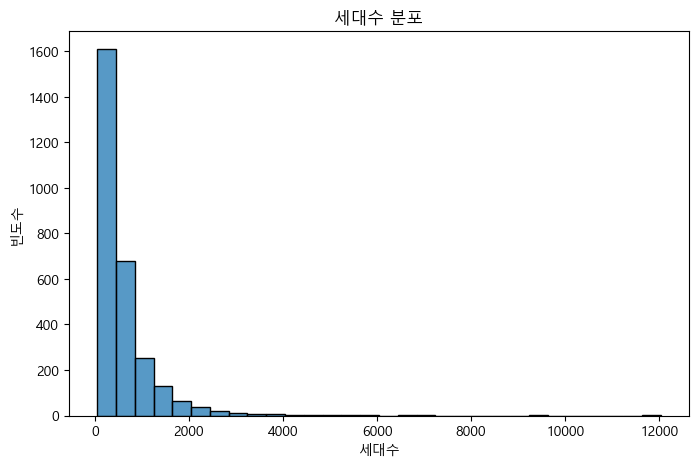

In [102]:
import matplotlib.pyplot as plt
import seaborn as sns


# 히스토그램으로 분포 시각화
plt.figure(figsize=(8,5))
sns.histplot(apt['세대수'], bins=30, kde=False)
plt.title('세대수 분포')
plt.xlabel('세대수')
plt.ylabel('빈도수')
plt.show()

In [114]:
threshold = apt['세대수'].quantile(0.97)
print(f"상위 5% 기준 세대수 임계값: {threshold}")

# threshold 이상의 세대수를 가진 아파트만 필터링
large_apt = apt[apt['세대수'] >= threshold]
print(f"상위 5% 아파트 개수: {len(large_apt)}")

상위 5% 기준 세대수 임계값: 2198.08
상위 5% 아파트 개수: 85


In [105]:
large_apt.info()

<class 'pandas.core.frame.DataFrame'>
Index: 142 entries, 1592 to 2828
Data columns (total 8 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   아파트명    142 non-null    object 
 1   도로명주소   141 non-null    object 
 2   시군구     142 non-null    object 
 3   읍면동     142 non-null    object 
 4   세대수     142 non-null    int64  
 5   lon     142 non-null    object 
 6   lat     142 non-null    float64
 7   정제주소    141 non-null    object 
dtypes: float64(1), int64(1), object(6)
memory usage: 10.0+ KB


In [106]:
large_apt.isnull().sum()

아파트명     0
도로명주소    1
시군구      0
읍면동      0
세대수      0
lon      0
lat      0
정제주소     1
dtype: int64

In [107]:
large_apt = large_apt.dropna(subset=['lat'])

In [108]:
large_apt.isnull().sum()

아파트명     0
도로명주소    1
시군구      0
읍면동      0
세대수      0
lon      0
lat      0
정제주소     1
dtype: int64

In [109]:
# 특정 칼럼(예: '도로명주소', '정제주소', 'lon', 'lat') 중 결측인 행만
large_apt[large_apt[['정제주소', 'lon', 'lat']].isnull().any(axis=1)]
large_apt = large_apt[['아파트명','세대수','시군구','lon','lat']]

In [110]:
large_apt.head()

,아파트명,세대수,시군구,lon,lat
1592,"길음뉴타운푸르지오아파트2,3단지",2068,성북구,127.0162373,37.611816
1607,시흥벽산1단지,1772,금천구,126.9196921,37.451127
1608,래미안장안2차,1786,동대문구,127.0754092,37.573973
1609,중계주공2단지,1800,노원구,127.0779964,37.657956
1610,SH성산아파트,1807,마포구,126.9014624,37.564311


In [111]:
large_apt.isnull().sum()

아파트명    0
세대수     0
시군구     0
lon     0
lat     0
dtype: int64

In [ ]:
'''mask_도로명 = apt['도로명주소'].isnull()

mask_lon = apt['lon'].isnull()
mask_lat = apt['lat'].isnull()

# 1. 모두 결측
all_null = apt[mask_도로명 & mask_lon & mask_lat]

# 2. 주소는 있는데 좌표만 결측
addo_xyx = apt[~(mask_도로명) & (mask_lon | mask_lat)]

# 3. 좌표는 있는데 주소가 없음
addx_xyo = apt[(mask_도로명) & ~(mask_lon | mask_lat)]'''



In [ ]:
'''print("📦 모두 결측:", len(all_null))
print("📍 주소는 있는데 좌표 없음:", len(addo_xyx))
print("🧭 좌표는 있는데 주소 없음:", len(addx_xyo))'''

📦 모두 결측: 11
📍 주소는 있는데 좌표 없음: 29
🧭 좌표는 있는데 주소 없음: 52


In [ ]:
#addo_xyx

,아파트명,도로명주소,시군구,읍면동,세대수,lon,lat,정제주소
2278,삼성파크아파트,서울특별시 강남구 삼성동 126,강남구,삼성동,114,NaN,NaN,서울특별시 강남구 삼성동 126
2280,세방하이빌,서울특별시 강남구 역삼동 771-4,강남구,역삼동,67,NaN,NaN,서울특별시 강남구 역삼동 771-4
2536,지밸리소홈,서울특별시 영등포구 도림천로19길 11,영등포구,대림동,299,NaN,NaN,서울특별시 영등포구 도림천로19길 11
2556,문래롯데캐슬아파트,서울특별시 영등포구 선유로9길 30,영등포구,문래동6가,499,NaN,NaN,서울특별시 영등포구 선유로9길 30
2560,용답동힐데스하임 청년주택,서울특별시 성동구 천호대로 416,성동구,용답동,170,NaN,NaN,서울특별시 성동구 천호대로 416
2594,개봉역 센트레빌레우스,서울특별시 구로구 경인로 302,구로구,개봉동,1089,NaN,NaN,서울특별시 구로구 경인로 302
2623,더클래식동작,서울특별시 동작구 노량진로8길 55,동작구,노량진동,272,NaN,NaN,서울특별시 동작구 노량진로8길 55
2629,여의도더리브스타일,서울특별시 영등포구 경인로 900,영등포구,영등포동1가,185,NaN,NaN,서울특별시 영등포구 경인로 900
2634,지웰홈스 왕십리,서울특별시 성동구 고산자로14길 26,성동구,행당동,299,NaN,NaN,서울특별시 성동구 고산자로14길 26
2641,이랜드PEER 신촌 청년주택,서울특별시 마포구 서강로 75-16,마포구,창전동,589,NaN,NaN,서울특별시 마포구 서강로 75-16


In [ ]:
#apt.isnull().sum()

아파트명      0
도로명주소    63
시군구       0
읍면동       0
세대수       0
lon      40
lat      40
정제주소     63
dtype: int64

In [ ]:
'''mask = apt['정제주소'].notnull() & apt['lon'].isnull()

# 해당 조건의 행만 좌표 추출 수행
apt.loc[mask, ['lat', 'lon']] = apt.loc[mask, '정제주소'].apply(
    lambda x: pd.Series(kakao_geocode(x, api_key))
)

apt.isnull().sum()'''

[1차 실패] 주소: 서울특별시 강남구 삼성동 126
[1차 실패] 주소: 서울특별시 강남구 역삼동 771-4
[1차 실패] 주소: 서울특별시 영등포구 도림천로19길 11
[1차 실패] 주소: 서울특별시 영등포구 선유로9길 30
[1차 실패] 주소: 서울특별시 성동구 천호대로 416
[1차 실패] 주소: 서울특별시 구로구 경인로 302
[1차 실패] 주소: 서울특별시 동작구 노량진로8길 55
[1차 실패] 주소: 서울특별시 영등포구 경인로 900
[1차 실패] 주소: 서울특별시 성동구 고산자로14길 26
[1차 실패] 주소: 서울특별시 마포구 서강로 75-16
[1차 실패] 주소: 서울특별시 강동구 아리수로93가길 77
[1차 실패] 주소: 서울특별시 강동구 고덕로98길 29
[1차 실패] 주소: 서울특별시 중구 동호로33길 15
[1차 실패] 주소: 서울특별시 동대문구 장안벚꽃로 317
[1차 실패] 주소: 서울특별시 성북구 정릉로10가길 6-31
[1차 실패] 주소: 서울특별시 서초구 반포대로27길 13
[1차 실패] 주소: 서울특별시 동대문구 외대역동로 63-12
[1차 실패] 주소: 서울특별시 강북구 도봉로 290
[1차 실패] 주소: 서울특별시 강동구 고덕로98길 161
[1차 실패] 주소: 서울특별시 중랑구 공릉로2길 8-4
[1차 실패] 주소: 서울특별시 중랑구 동일로 952
[1차 실패] 주소: 서울특별시 중구 중림로 21
[1차 실패] 주소: 서울특별시 강동구 천호대로 989
[1차 실패] 주소: 서울특별시 구로구 중앙로5길 59
[1차 실패] 주소: 서울특별시 동대문구 이문로 37
[1차 실패] 주소: 서울특별시 영등포구 당산로 83
[1차 실패] 주소: 서울특별시 구로구 가마산로 271
[1차 실패] 주소: 서울특별시 광진구 천호대로 517
[1차 실패] 주소: 서울특별시 동대문구 장한로 91


아파트명      0
도로명주소    63
시군구       0
읍면동       0
세대수       0
lon      40
lat      40
정제주소     63
dtype: int64

In [15]:
apt = apt.loc[:, ~apt.columns.duplicated()]

In [ ]:
'''# 아파트명 기준으로 두 데이터프레임 병합 (left join)
apt = apt.merge(addo_xyx[['아파트명', 'lat', 'lon']], on='아파트명', how='left', suffixes=('', '_new'))

# 기존 좌표가 없으면 새 좌표로 채우기
apt['lat'] = apt['lat'].fillna(apt['lat_new'])
apt['lon'] = apt['lon'].fillna(apt['lon_new'])

# 임시 컬럼 삭제
apt.drop(columns=['lat_new', 'lon_new'], inplace=True)'''

C:\Users\leehy\AppData\Local\Temp\ipykernel_44224\1755729782.py:5: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  apt['lat'] = apt['lat'].fillna(apt['lat_new'])


In [ ]:
#addo_xyx.head()

,아파트명,도로명주소,시군구,읍면동,세대수,lon,lat,정제주소
2278,삼성파크아파트,서울특별시 강남구 삼성동 126,강남구,삼성동,114,None,None,서울특별시 강남구 삼성동 126
2280,세방하이빌,서울특별시 강남구 역삼동 771-4,강남구,역삼동,67,None,None,서울특별시 강남구 역삼동 771-4
2536,지밸리소홈,서울특별시 영등포구 도림천로19길 11,영등포구,대림동,299,None,None,서울특별시 영등포구 도림천로19길 11
2556,문래롯데캐슬아파트,서울특별시 영등포구 선유로9길 30,영등포구,문래동6가,499,None,None,서울특별시 영등포구 선유로9길 30
2560,용답동힐데스하임 청년주택,서울특별시 성동구 천호대로 416,성동구,용답동,170,None,None,서울특별시 성동구 천호대로 416


In [ ]:
#apt.isnull().sum()

아파트명      0
도로명주소    63
시군구       0
읍면동       0
세대수       0
lon      40
lat      40
정제주소     63
dtype: int64

9. 장애물없는 시설 데이터 -> 가중치에 사용

사용 칼럼 = ['인증등급','시군구','지역(시설)명','인증대상','용도구분']  
지역 코드에서 서울, 서울 특별시만 추출  
지역 시설 명에서 화장실|노인시설|정거장 등 제거  

용도구분 중 드랍 데이터 
drop_uses = [
    '도로',
    '묘지관련시설',
    '자원순환관련시설',
    '교정시설 및 군사시설',
    '공장',
    '자동차 관련 시설',
    '숙박시설',
    '관광휴게시설',
    '공동주택',
    '교통수단',
    '여객시설',
    '운수시설',
    '교육연구시설',
    '종교시설','판매시설'
]


In [116]:
alpha_row.head()

,연번,인증번호,인증구분,인증등급,지역코드,시군구,지역(시설)명,인증대상,신청기관,면적,용도구분,인증일자,인증만료일,인증기관
0,1,1,예비,최우수,전라남도,순천시,주암댐효나눔복지센터,건축물,한국 수자원공사,891.49,노유자시설,2008-10-30,본인증 교부전 또는 사용승인 후 1년 이내,한국장애인개발원
1,2,2,예비,최우수,서울특별시,성북구,성북구청사,건축물,성북구청,26980.3,업무시설,2008-12-29,본인증 교부전 또는 사용승인 후 1년 이내,한국장애인개발원
2,3,3,예비,최우수,경기도,양평군,양평군장애인종합복지관,건축물,(주)대경종합건축사사무소,2684.94,노유자시설,2008-12-29,본인증 교부전 또는 사용승인 후 1년 이내,한국장애인개발원
3,4,1,본,최우수,대전광역시,서구,대전시청사,건축물,대전광역시,77927.87,업무시설,2008-12-30,2013-12-29,한국장애인개발원
4,5,4,예비,최우수,서울특별시,송파구,문정도시개발사업,지역,SH공사,NaN,공동주택,2009-01-13,본인증 교부전 또는 사용승인 후 1년 이내,한국토지주택공사


In [117]:
alpha_row.isnull().sum()

연번           0
인증번호         0
인증구분         0
인증등급         0
지역코드         0
시군구        305
지역(시설)명      0
인증대상         0
신청기관         2
면적         196
용도구분         0
인증일자         0
인증만료일        0
인증기관         0
dtype: int64

In [118]:
alpha_row.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17662 entries, 0 to 17661
Data columns (total 14 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   연번       17662 non-null  int64 
 1   인증번호     17662 non-null  int64 
 2   인증구분     17662 non-null  object
 3   인증등급     17662 non-null  object
 4   지역코드     17662 non-null  object
 5   시군구      17357 non-null  object
 6   지역(시설)명  17662 non-null  object
 7   인증대상     17662 non-null  object
 8   신청기관     17660 non-null  object
 9   면적       17466 non-null  object
 10  용도구분     17662 non-null  object
 11  인증일자     17662 non-null  object
 12  인증만료일    17662 non-null  object
 13  인증기관     17662 non-null  object
dtypes: int64(2), object(12)
memory usage: 1.9+ MB


In [119]:
# '지역코드' 칼럼이 '서울'로 시작하는 행 필터링
alpha = alpha_row[alpha_row['지역코드'].str.startswith('서울')]


In [120]:
alpha.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1393 entries, 1 to 17654
Data columns (total 14 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   연번       1393 non-null   int64 
 1   인증번호     1393 non-null   int64 
 2   인증구분     1393 non-null   object
 3   인증등급     1393 non-null   object
 4   지역코드     1393 non-null   object
 5   시군구      1393 non-null   object
 6   지역(시설)명  1393 non-null   object
 7   인증대상     1393 non-null   object
 8   신청기관     1392 non-null   object
 9   면적       1354 non-null   object
 10  용도구분     1393 non-null   object
 11  인증일자     1393 non-null   object
 12  인증만료일    1393 non-null   object
 13  인증기관     1393 non-null   object
dtypes: int64(2), object(12)
memory usage: 163.2+ KB


In [121]:
alpha['용도구분'].value_counts()

용도구분
노유자시설          331
업무시설           258
제1종 근린생활시설     213
교육연구시설         142
공동주택           133
문화 및 집회시설       65
자동차 관련 시설       51
운동시설            39
여객시설            38
공원              25
운수시설            24
수련시설            18
제2종 근린생활시설      14
근린생활시설          13
교정시설 및 군사시설      5
판매시설             5
교통수단             5
공장               3
의료시설             2
자원순환관련시설         2
묘지관련시설           2
숙박시설             2
도로               1
종교시설             1
관광휴게시설           1
Name: count, dtype: int64

In [122]:
alpha = alpha[['인증등급','시군구','지역(시설)명','인증대상','용도구분']]

In [123]:
alpha.head()

,인증등급,시군구,지역(시설)명,인증대상,용도구분
1,최우수,성북구,성북구청사,건축물,업무시설
4,최우수,송파구,문정도시개발사업,지역,공동주택
5,최우수,중구,동대문 디자인 플라자 & 파크,건축물,문화 및 집회시설
8,최우수,성북구,성북구청사,건축물,업무시설
10,최우수,마포구,서울 연남 차이나타운 중화문화거리,도로,도로


In [ ]:
drop_uses = [
    '도로',
    '묘지관련시설',
    '자원순환관련시설',
    '교정시설 및 군사시설',
    '공장',
    '자동차 관련 시설',
    '숙박시설',
    '관광휴게시설',
    '교통수단',
    '공동주택',
    '여객시설',
    '운수시설',
    '교육연구시설',
    '종교시설','판매시설'
]

alpha = alpha[~alpha['용도구분'].isin(drop_uses)].reset_index(drop=True)

drop_keywords = ['공사', '신축', '증축', '조성', '정비기반시설', '계획', '건립', '예정', '노인','어린이','화장실','정거장']
pattern = '|'.join(drop_keywords)
alpha = alpha[~alpha['지역(시설)명'].str.contains(pattern, na=False)]
alpha.head()

,인증등급,시군구,지역(시설)명,인증대상,용도구분
0,최우수,성북구,성북구청사,건축물,업무시설
1,최우수,송파구,문정도시개발사업,지역,공동주택
2,최우수,중구,동대문 디자인 플라자 & 파크,건축물,문화 및 집회시설
3,최우수,성북구,성북구청사,건축물,업무시설
4,최우수,종로구,광화문광장,공원,공원


In [125]:
alpha.info()

<class 'pandas.core.frame.DataFrame'>
Index: 783 entries, 0 to 1110
Data columns (total 5 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   인증등급     783 non-null    object
 1   시군구      783 non-null    object
 2   지역(시설)명  783 non-null    object
 3   인증대상     783 non-null    object
 4   용도구분     783 non-null    object
dtypes: object(5)
memory usage: 36.7+ KB


In [126]:
alpha['인증대상'].value_counts()

인증대상
건축물    762
공원      20
지역       1
Name: count, dtype: int64

In [127]:
alpha['용도구분'].value_counts()

용도구분
업무시설          219
제1종 근린생활시설    173
공동주택          124
노유자시설         123
문화 및 집회시설      53
운동시설           34
공원             20
수련시설           17
근린생활시설         11
제2종 근린생활시설      7
의료시설            2
Name: count, dtype: int64

In [128]:
alpha = alpha.drop_duplicates(subset=['지역(시설)명', '용도구분'])


In [129]:
alpha[alpha['인증대상']== '건축물']

,인증등급,시군구,지역(시설)명,인증대상,용도구분
0,최우수,성북구,성북구청사,건축물,업무시설
2,최우수,중구,동대문 디자인 플라자 & 파크,건축물,문화 및 집회시설
5,최우수,중구,서울특별시 청사,건축물,업무시설
6,우수,광진구,구의3재정비촉진구역,건축물,공동주택
7,우수,양천구,신정1재정비촉진구역1-1지구 1단지,건축물,공동주택
...,...,...,...,...,...
1098,우수,노원구,노원구 중계문화보건센터,건축물,업무시설
1102,우수,성동구,성동경찰서 용답파출소,건축물,제1종 근린생활시설
1106,우수,양천구,신월1동 월성경로당,건축물,노유자시설
1109,일반,중랑구,플라이쿱 면목,건축물,제2종 근린생활시설


In [130]:
alpha[alpha['용도구분']== '공원']

,인증등급,시군구,지역(시설)명,인증대상,용도구분
4,최우수,종로구,광화문광장,공원,공원
50,우수,영등포구,여의도공원,공원,공원
651,우수,영등포구,당산근린공원,공원,공원
762,우수,종로구,"광화문광장(시민광장, 역사광장)",공원,공원
879,우수,강남구,개포주공4단지 주택재건축정비사업 근린공원,공원,공원
934,일반,동대문구,동부청과 시장정비사업 가로공원,공원,공원
973,우수,강남구,개포17 근린공원,공원,공원
1003,일반,강남구,개포주공1 소공원,공원,공원
1006,우수,은평구,역촌1주택재건축 정비구역 내 소공원1,공원,공원
1007,최우수,강남구,역촌1주택재건축 정비구역 내 소공원2,공원,공원


In [131]:
alpha = alpha.rename(columns = { '지역(시설)명' : '시설명'
})

In [132]:
alpha[['lat', 'lon', '출처']] = alpha.apply(lambda row: extract_coords_from_facility(row, api_key), axis=1)

In [133]:
alpha.head()

,인증등급,시군구,시설명,인증대상,용도구분,lat,lon,출처
0,최우수,성북구,성북구청사,건축물,업무시설,37.585855,127.021367,keyword
1,최우수,송파구,문정도시개발사업,지역,공동주택,NaN,NaN,fail
2,최우수,중구,동대문 디자인 플라자 & 파크,건축물,문화 및 집회시설,37.568734,127.007667,keyword
4,최우수,종로구,광화문광장,공원,공원,37.572603,126.976916,keyword
5,최우수,중구,서울특별시 청사,건축물,업무시설,37.574941,126.975141,keyword


In [134]:
alpha.isnull().sum()

인증등급      0
시군구       0
시설명       0
인증대상      0
용도구분      0
lat     258
lon     258
출처        0
dtype: int64

In [92]:
alpha.info()

<class 'pandas.core.frame.DataFrame'>
Index: 578 entries, 0 to 977
Data columns (total 8 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   인증등급    578 non-null    object 
 1   시군구     578 non-null    object 
 2   시설명     578 non-null    object 
 3   인증대상    578 non-null    object 
 4   용도구분    578 non-null    object 
 5   lat     393 non-null    float64
 6   lon     393 non-null    float64
 7   출처      578 non-null    object 
dtypes: float64(2), object(6)
memory usage: 40.6+ KB


In [93]:
alpha[alpha['출처']== 'fail']

,인증등급,시군구,시설명,인증대상,용도구분,lat,lon,출처
6,최우수,양천구,목5동 통합청사,건축물,업무시설,NaN,NaN,fail
11,최우수,강남구,장애인행복서비스센터,건축물,업무시설,NaN,NaN,fail
17,우수,송파구,실내테니스경기장,건축물,운동시설,NaN,NaN,fail
26,최우수,송파구,서울동부지방검찰청사,건축물,업무시설,NaN,NaN,fail
39,최우수,구로구,서남권50+캠퍼스,건축물,노유자시설,NaN,NaN,fail
...,...,...,...,...,...,...,...,...
945,우수,서초구,서초구 방배동 공공청사(아버지센터),건축물,업무시설,NaN,NaN,fail
946,우수,노원구,노원구 월계동 청년주택 내 공공도서관 부분 기부채납,건축물,제1종 근린생활시설,NaN,NaN,fail
951,우수,마포구,마포 새빛문화숲 내 주민편익시설,건축물,운동시설,NaN,NaN,fail
965,우수,노원구,노원구 중계문화보건센터,건축물,업무시설,NaN,NaN,fail


In [96]:
alpha = alpha.dropna(subset=['lat']).reset_index(drop=True)
alpha = alpha.drop(columns=['출처'])

# 지도에 위치 표기.
시각화 자료

In [79]:
def add_markers(map_obj, df, lat_col, lon_col, popup_col=None, color='blue', radius=5):
    for _, row in df.iterrows():
        lat = row[lat_col]
        lon = row[lon_col]

        if pd.notnull(lat) and pd.notnull(lon):
            folium.CircleMarker(
                location=[lat, lon],
                radius=radius,
                color=color,
                fill=True,
                fill_opacity=0.6,
                popup=row[popup_col] if popup_col and popup_col in row else None
            ).add_to(map_obj)            

In [80]:
# 중심점 설정 (서울 중심)
m = folium.Map(location=[37.5665, 126.9780], zoom_start=11)

#2. 공원
add_markers(m, park, lat_col='lat', lon_col='lon', popup_col='공원명', color='red')

#3.일자리
add_markers(m, work, lat_col='lat', lon_col='lon', popup_col='사업체명', color='orange')

#4. 학교
add_markers(m, school, lat_col='lat',lon_col='lon',popup_col='학교명',color='yellow')

#5. 장애인시설
add_markers(m, organ, lat_col='lat',lon_col='lon',popup_col='시설명',color='green')

#6. 병원
add_markers(m, hospital, lat_col='lat', lon_col='lon', popup_col='사업장명', color='blue')

#7. 도서관
add_markers(m, library, lat_col='lat', lon_col='lon', popup_col='도서관명', color='purple')



In [81]:
m

In [82]:
#전처리 데이터파일 저장
'''
bus_sta.to_csv("C:/Users/leehy/OneDrive/바탕 화면/study/통계공모전/전처리데이터/bus_sta_Data.csv", index=False, encoding="utf-8-sig") 
park.to_csv("C:/Users/leehy/OneDrive/바탕 화면/study/통계공모전/전처리데이터/park_Data.csv", index=False, encoding="utf-8-sig") 
school.to_csv("C:/Users/leehy/OneDrive/바탕 화면/study/통계공모전/전처리데이터/school_Data.csv", index=False, encoding="utf-8-sig") 
work.to_csv("C:/Users/leehy/OneDrive/바탕 화면/study/통계공모전/전처리데이터/work_Data.csv", index=False, encoding="utf-8-sig") 
organ.to_csv("C:/Users/leehy/OneDrive/바탕 화면/study/통계공모전/전처리데이터/organ_Data.csv", index=False, encoding="utf-8-sig") 
hospital.to_csv("C:/Users/leehy/OneDrive/바탕 화면/study/통계공모전/전처리데이터/hospital_Data.csv", index=False, encoding="utf-8-sig") '''

'\nbus_sta.to_csv("C:/Users/leehy/OneDrive/바탕 화면/study/통계공모전/전처리데이터/bus_sta_Data.csv", index=False, encoding="utf-8-sig") \npark.to_csv("C:/Users/leehy/OneDrive/바탕 화면/study/통계공모전/전처리데이터/park_Data.csv", index=False, encoding="utf-8-sig") \nschool.to_csv("C:/Users/leehy/OneDrive/바탕 화면/study/통계공모전/전처리데이터/school_Data.csv", index=False, encoding="utf-8-sig") \nwork.to_csv("C:/Users/leehy/OneDrive/바탕 화면/study/통계공모전/전처리데이터/work_Data.csv", index=False, encoding="utf-8-sig") \norgan.to_csv("C:/Users/leehy/OneDrive/바탕 화면/study/통계공모전/전처리데이터/organ_Data.csv", index=False, encoding="utf-8-sig") \nhospital.to_csv("C:/Users/leehy/OneDrive/바탕 화면/study/통계공모전/전처리데이터/hospital_Data.csv", index=False, encoding="utf-8-sig") '

In [ ]:

library.to_csv("C:/Users/leehy/OneDrive/바탕 화면/study/통계공모전/전처리데이터/library_Data.csv", index=False, encoding="utf-8-sig")


In [115]:
large_apt.to_csv("C:/Users/leehy/OneDrive/바탕 화면/study/통계공모전/전처리데이터/large_apt3_Data.csv", index=False, encoding="utf-8-sig")


In [97]:
alpha.to_csv("C:/Users/leehy/OneDrive/바탕 화면/study/통계공모전/전처리데이터/alpha_Data.csv", index=False, encoding="utf-8-sig")


In [84]:
#dbsan

print("정류소 수  ",len(bus_sta))
print("공원 수  ",len(park))
print("일자리 수  ",len(work))
print("학교교 수  ",len(school))
print("장애인 시설 수  ",len(organ))
print("병원원 수  ",len(hospital))

정류소 수   11301
공원 수   128
일자리 수   0
학교교 수   32
장애인 시설 수   270
병원원 수   562


In [85]:
def cluster_plot(df, name, min_cluster_size = 5):
    coords = df[['lat','lon']].dropna().values

    clusterer = hdbscan.HDBSCAN(min_cluster_size=min_cluster_size, metric='haversine')
    df['cluster'] = clusterer.fit_predict(np.radians(coords)) 

    plt.figure(figsize=(8, 6))
    sns.scatterplot(
        x='lon', y='lat',
        hue='cluster',
        data=df[df['cluster'] != -1],  # 잡음 제외
        palette='tab10', s=50, legend='full'
    )
    plt.title(f'{name} - HDBSCAN 클러스터링')
    plt.xlabel('Longitude')
    plt.ylabel('Latitude')
    plt.legend(title='Cluster')
    plt.grid(True)
    plt.show()
    
    return df


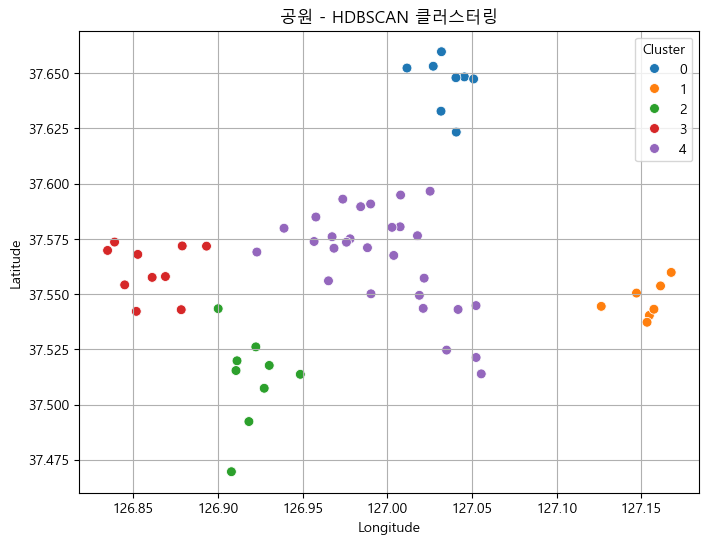

In [86]:
park_clustered = cluster_plot(park, '공원')

In [87]:
work_clustered = cluster_plot(work, '근무지')

ValueError: Found array with 0 sample(s) (shape=(0, 2)) while a minimum of 1 is required.

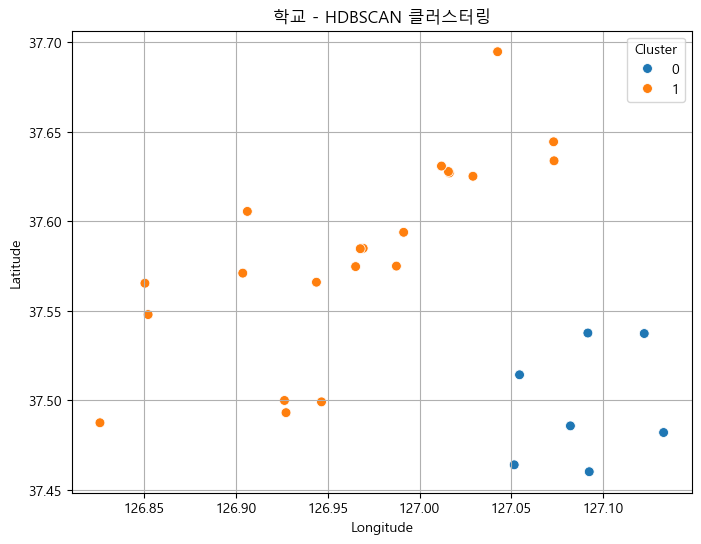

In [ ]:
school_clustered = cluster_plot(school, '학교')

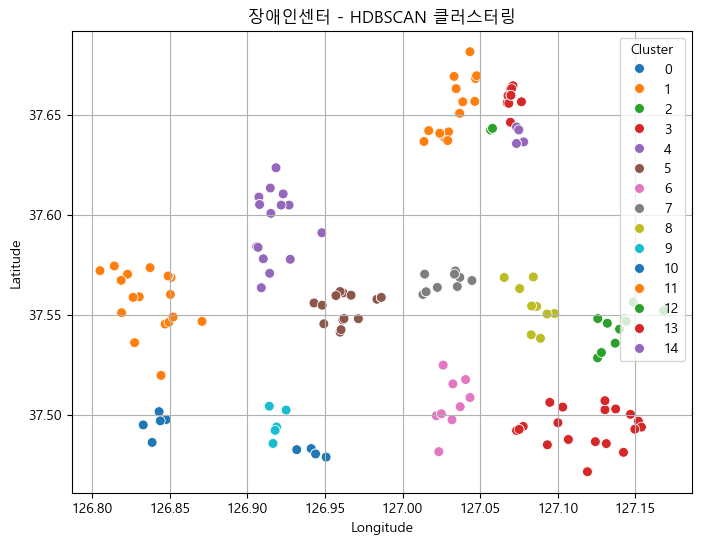

In [ ]:
organ_clustered = cluster_plot(organ, '장애인센터')

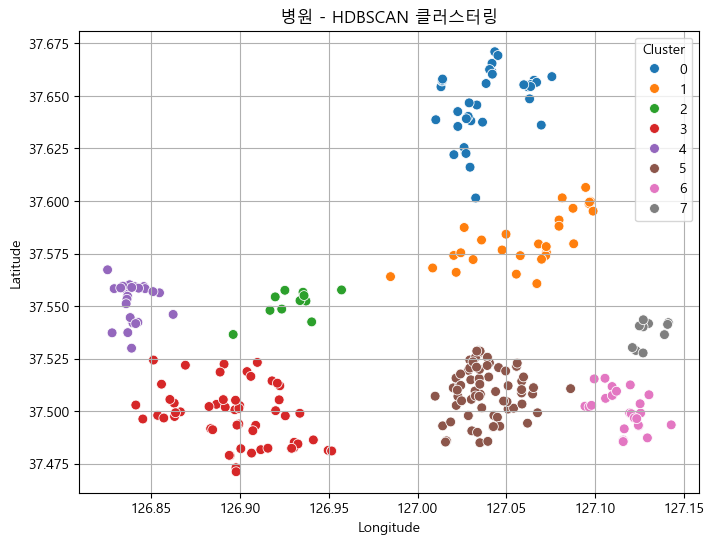

In [ ]:
hospital_clustered = cluster_plot(hospital, '병원', min_cluster_size=10)


In [ ]:
def plot_clusters_on_map(df, name_col='시설명', lat_col='lat', lon_col='lon', cluster_col='cluster', zoom=11):
  
    # 중심 좌표 설정
    center_lat = df[lat_col].mean()
    center_lon = df[lon_col].mean()
    fmap = folium.Map(location=[center_lat, center_lon], zoom_start=zoom)
    
    # 색상 팔레트 (12개 이상 필요하면 순환 사용)
    cluster_colors = [
        'red', 'blue', 'green', 'purple', 'orange', 'darkred', 'lightblue',
        'beige', 'darkgreen', 'cadetblue', 'darkpurple', 'pink', 'lightgreen',
        'lightgray', 'black'
    ]
    
    # 마커 클러스터링
    marker_cluster = MarkerCluster().add_to(fmap)

    for _, row in df.iterrows():
        cluster = row[cluster_col]
        color = cluster_colors[cluster % len(cluster_colors)] if cluster != -1 else 'gray'
        name = row.get(name_col, '이름 없음')

        folium.CircleMarker(
            location=[row[lat_col], row[lon_col]],
            radius=4,
            color=color,
            fill=True,
            fill_color=color,
            fill_opacity=0.7,
            popup=f"{name} / 클러스터: {cluster}"
        ).add_to(marker_cluster)
    
    return fmap

In [88]:
plot_clusters_on_map(park, name_col='공원명')

NameError: name 'plot_clusters_on_map' is not defined

In [89]:
plot_clusters_on_map(work, name_col='근무지명')

NameError: name 'plot_clusters_on_map' is not defined

In [90]:
plot_clusters_on_map(school, name_col='학교명')

NameError: name 'plot_clusters_on_map' is not defined

In [91]:
plot_clusters_on_map(organ, name_col='시설명')

NameError: name 'plot_clusters_on_map' is not defined

In [92]:
plot_clusters_on_map(hospital, name_col='병원명')

NameError: name 'plot_clusters_on_map' is not defined

In [93]:
# 전체데이터 클러스터링 

# 각 데이터에 'source' 컬럼 추가
park['source'] = '공원'
work['source'] = '일자리'
school['source'] = '학교'
organ['source'] = '기관'
hospital['source'] = '병원'

# 가중치 적용 후 병합
df_combined = pd.concat([
    park.loc[park.index.repeat(1)],
    work.loc[work.index.repeat(1)],
    school.loc[school.index.repeat(1)],
    organ.loc[organ.index.repeat(1)],
    hospital.loc[hospital.index.repeat(1)],
], ignore_index=True)  # 추후 가중치 수정 


C:\Users\leehy\AppData\Local\Temp\ipykernel_37796\2308892862.py:11: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df_combined = pd.concat([


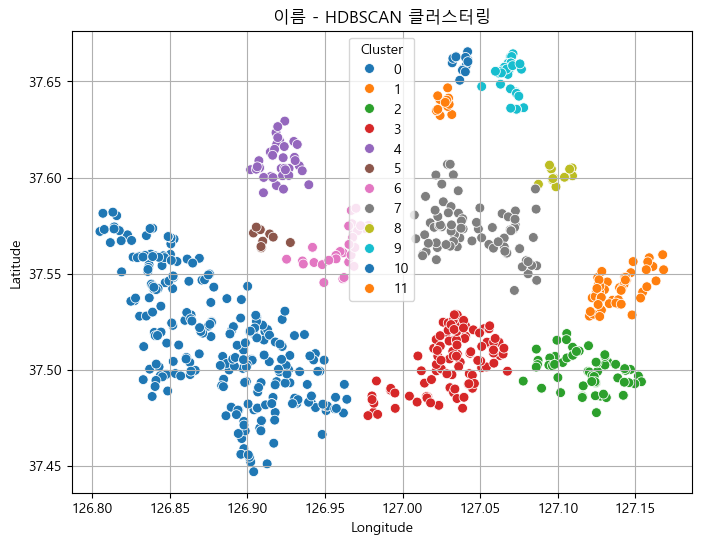

In [94]:
combined_clustered = cluster_plot(df_combined, '이름', min_cluster_size=10)

In [105]:
plot_clusters_on_map(df_combined, name_col='이름')

NameError: name 'plot_clusters_on_map' is not defined

In [106]:
plot_clusters_on_map(df_combined, name_col='이름').save('전체_클러스터_지도.html')

NameError: name 'plot_clusters_on_map' is not defined

In [96]:
webbrowser.open('전체_클러스터_지도.html')

True

In [97]:
park.head()

,연번,공원명,지역,공원주소,lon,lat,cluster,source
0,1,남산공원,중구,서울특별시 중구 삼일대로 231(예장동),126.990377,37.550140,4,공원
1,2,길동생태공원,강동구,서울특별시 강동구 천호대로 1291(길동생태공원),127.154779,37.540394,1,공원
2,3,서울대공원,과천시,경기도 과천시 대공원광장로 102,127.019846,37.426449,-1,공원
3,4,서울숲,성동구,서울특별시 성동구 뚝섬로 273 (성수동1가),127.041798,37.543072,4,공원
4,5,월드컵공원,마포구,서울특별시 마포구 하늘공원로 84(월드컵공원),126.878907,37.571805,3,공원


In [98]:
bus_sta.head()

,ARS_ID,정류소명,X좌표,Y좌표,정류소타입
0,1001,종로2가사거리,126.987752,37.569806,중앙차로
1,1002,창경궁.서울대학교병원,126.996521,37.579433,중앙차로
2,1003,명륜3가.성대입구,126.998251,37.582580,중앙차로
3,1004,종로2가.삼일교,126.987613,37.568579,중앙차로
4,1005,혜화동로터리.여운형활동터,127.001744,37.586243,중앙차로


In [99]:
school.head()

,학교명,관할조직명,도로명주소,lat,lon,정제주소,source
0,서울서진학교,서울특별시교육청,서울특별시 강서구 양천로55길 22,37.565477,126.850622,서울특별시 강서구 양천로55길 22,학교
1,서울도솔학교,서울특별시교육청,서울특별시 도봉구 평화로15번길 9-26,37.694840,127.042477,서울특별시 도봉구 평화로15번길 9-26,학교
2,서울나래학교,서울특별시교육청,서울특별시 서초구 염곡안1길 25,37.464025,127.051498,서울특별시 서초구 염곡안1길 25,학교
3,서울새롬학교,서울특별시교육청,서울특별시 관악구 보라매로 44,37.493168,126.927372,서울특별시 관악구 보라매로 44,학교
4,서울효정학교,서울특별시교육청,서울특별시 강북구 삼양로63길 33,37.627130,127.016222,서울특별시 강북구 삼양로63길 33,학교


In [100]:
organ.head()

,시설명,시설코드,시설종류명(시설유형),시군구명,시설주소,정제주소,lat,lon,source
0,방이복지관,A5039,(장애인복지시설) 장애인복지관,송파구,"서울특별시 송파구 백제고분로37길 4, 5층 (석촌동)",서울특별시 송파구 백제고분로37길,37.503717,127.103231,기관
1,서울시각장애인복지관,A5105,(장애인복지시설) 장애인복지관,송파구,서울특별시 송파구 삼학사로19길 27 (삼전동),서울특별시 송파구 삼학사로19길,37.506082,127.094896,기관
2,서울시립발달장애인복지관,A5108,(장애인복지시설) 장애인복지관,동작구,서울특별시 동작구 여의대방로20나길 33 (신대방동),서울특별시 동작구 여의대방로20나길,37.492087,126.917852,기관
3,청음복지관,A5237,(장애인복지시설) 장애인복지관,강남구,서울특별시 강남구 봉은사로50길 6 (역삼동),서울특별시 강남구 봉은사로50길,37.508487,127.043450,기관
4,마포장애인종합복지관,A5241,(장애인복지시설) 장애인복지관,마포구,"서울특별시 마포구 성산로4길 35 (성산동, 마포장애인종합복지관)",서울특별시 마포구 성산로4길,37.563392,126.908910,기관


In [101]:
hospital.head()

,관리번호,사업장명,업태구분명,지번주소,도로명주소,좌표정보(X),좌표정보(Y),lon,lat,정제주소,source
1,PHMA220193140033021200001,서울스마트요양병원,요양병원(일반요양병원),서울특별시 양천구 신정동 1268 복합메디컬타운,"서울특별시 양천구 중앙로 181, 복합메디컬타운 3~8층 (신정동)",187181.28483799,445624.366466149,126.855685,37.512819,"서울특별시 양천구 중앙로 181, 복합메디컬타운 38층 (신정동)",병원
2,PHMA220063140033021200001,목동힘찬병원,병원,서울특별시 양천구 목동 404번지 3호,"서울특별시 양천구 신목로 120 (목동, 힘찬병원)",189047.941727937,446975.068504489,126.876847,37.524981,"서울특별시 양천구 신목로 120 (목동, 힘찬병원)",병원
3,PHMA220163090033021200001,서울사랑요양병원,요양병원(일반요양병원),서울특별시 도봉구 쌍문동 503-8 2~5층,"서울특별시 도봉구 삼양로 574, 2~5층 (쌍문동)",201098.761383515,461327.62658561,127.013171,37.654347,"서울특별시 도봉구 삼양로 574, 25층 (쌍문동)",병원
8,PHMA220083230034021201554,뉴스타트병원,병원,서울특별시 송파구 가락동 159번지 7호 뉴스타트병원,"서울특별시 송파구 송이로 76, 뉴스타트병원 (가락동)",210493.764941542,444103.26092079,127.119513,37.499098,"서울특별시 송파구 송이로 76, 뉴스타트병원 (가락동)",병원
9,PHMA220133220033021200003,기쁨정원치과병원,치과병원,"서울특별시 강남구 수서동 713번지 수서현대벤처빌 303호,315호","서울특별시 강남구 밤고개로1길 10, 315호 (수서동, 수서현대벤쳐빌)",208937.760652081,442873.588039887,127.101844,37.488024,"서울특별시 강남구 밤고개로1길 10, 315호 (수서동, 수서현대벤쳐빌)",병원


In [102]:
work.head()

,사업체명,관할지사,소재지,정제주소,lat,lon,source


In [103]:

df_cleaned = df_combined.copy()

# 이름 컬럼 통일
df_cleaned['이름'] = (
    df_cleaned['공원명']
    .combine_first(df_cleaned['학교명'])
    .combine_first(df_cleaned['시설명'])
    .combine_first(df_cleaned['사업장명'])
    .combine_first(df_cleaned['사업체명'])
)


df_cleaned['정제주소'] = df_cleaned['정제주소'].combine_first(df_cleaned['공원주소'])
combined= df_cleaned[['이름', '정제주소', 'lat', 'lon', 'source']]

In [104]:
combined.head()

,이름,정제주소,lat,lon,source
0,남산공원,서울특별시 중구 삼일대로 231(예장동),37.550140,126.990377,공원
1,길동생태공원,서울특별시 강동구 천호대로 1291(길동생태공원),37.540394,127.154779,공원
2,서울대공원,경기도 과천시 대공원광장로 102,37.426449,127.019846,공원
3,서울숲,서울특별시 성동구 뚝섬로 273 (성수동1가),37.543072,127.041798,공원
4,월드컵공원,서울특별시 마포구 하늘공원로 84(월드컵공원),37.571805,126.878907,공원


# 상관분석

아파트 인구밀집도와 장애인 인구 상관분석


In [18]:
dongjak_apt = pd.read_csv(r'C:/Users/leehy/OneDrive/바탕 화면/study/통계공모전/data/서울특별시 동작구_주택유형별 위치 정보 및 세대수 현황_20250405.csv', encoding='euc-kr')
dongjak_pp_raw = pd.read_csv(
    r'C:/Users/leehy/OneDrive/바탕 화면/study/통계공모전/data/동작구 장애인 현황(장애유형별_동별)_20250619100208.csv',
    encoding='utf-8'
)

In [9]:
dongjak_apt.head()

,연번,분류,건물명,행정동,주소,세대수,위도,경도
0,1,아파트,노량진우성,노량진1동,서울특별시 동작구 만양로8길 50,901,37.510304,126.946866
1,2,아파트,노량진삼익,노량진1동,서울특별시 동작구 만양로 84,175,37.511367,126.945226
2,3,아파트,"신동아리버파크(분양 1,696,임대 925)",노량진1동,서울특별시 동작구 만양로 19,2621,37.507073,126.945718
3,4,아파트,노량진쌍용예가,노량진1동,서울특별시 동작구 장승배기로16길 134,299,37.510265,126.943676
4,5,아파트,형인한강,노량진1동,서울특별시 동작구 만양로 36,73,37.507664,126.948235


In [11]:
dongjak_apt.columns = dongjak_apt.columns.str.strip()

In [12]:
dongjak_apt['분류'].value_counts()

분류
아파트     139
연립주택     21
주상복합     12
Name: count, dtype: int64

In [ ]:
dongjak_pp_raw

,동별(1),동별(2),동별(3),2024,2024.1,2024.2
0,동별(1),동별(2),동별(3),합계,합계,합계
1,동별(1),동별(2),동별(3),계,남자,여자
2,합계,동작구,소계,14038,8060,5978
3,합계,동작구,노량진2동,411,242,169
4,합계,동작구,상도1동,1465,830,635
5,합계,동작구,상도2동,899,526,373
6,합계,동작구,상도3동,1142,630,512
7,합계,동작구,상도4동,1327,796,531
8,합계,동작구,사당1동,741,435,306
9,합계,동작구,사당3동,765,468,297


In [40]:
aptsum = dongjak_apt.groupby('행정동')['세대수'].sum().reset_index()

dongjak_pp = dongjak_pp_raw.iloc[3:, [2, 3]].copy()
dongjak_pp.columns = ['행정동', '장애인수']

dongjak_pp = dongjak_pp[dongjak_pp['행정동'] != '기타']
dongjak_pp = dongjak_pp[dongjak_pp['장애인수'] != '-']

dongjak_pp['장애인수'] = pd.to_numeric(dongjak_pp['장애인수'])

dongjak_pp.reset_index(drop=True, inplace=True)


In [41]:
dongjak_pp

,행정동,장애인수
0,노량진2동,411
1,상도1동,1465
2,상도2동,899
3,상도3동,1142
4,상도4동,1327
5,사당1동,741
6,사당3동,765
7,사당4동,534
8,사당5동,527
9,대방동,1498


In [42]:
merged_df = pd.merge(aptsum, dongjak_pp, on='행정동', how='inner')

In [43]:
merged_df

,행정동,세대수,장애인수
0,노량진1동,4101,1225
1,노량진2동,86,411
2,대방동,6262,1498
3,사당1동,251,741
4,사당2동,4380,914
5,사당3동,5210,765
6,사당4동,914,534
7,사당5동,2681,527
8,상도1동,7941,1465
9,상도2동,7880,899


H0: 인구밀집도와 장애인 인구수 사이에 상관관계가 없다.   
H1: 인구밀집도와 장애인 인구수 사이에 상관관계가 있다

In [45]:
from scipy.stats import pearsonr


corr, p_value = pearsonr(merged_df['세대수'], merged_df['장애인수'])


In [32]:
print(f"세대수와 장애인수")
print(f"피어슨 상관계수: {corr}, p_value: {p_value}")

세대수와 장애인수
피어슨 상관계수: 0.41014535603147684, p_value: 0.12891075620669068


p_value 0.13 < 유의수준 0.05 이므로 대립가설 채택. 통계적으로 유의미함.  

인구밀집도(아파트세대수)와 장애인 인구는 유의미한 상관관계가 있음  

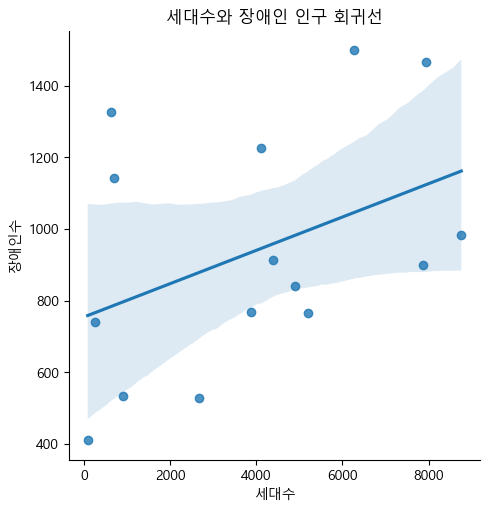

In [46]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.lmplot(x='세대수', y='장애인수', data=merged_df)
plt.title('세대수와 장애인 인구 회귀선')
plt.show()


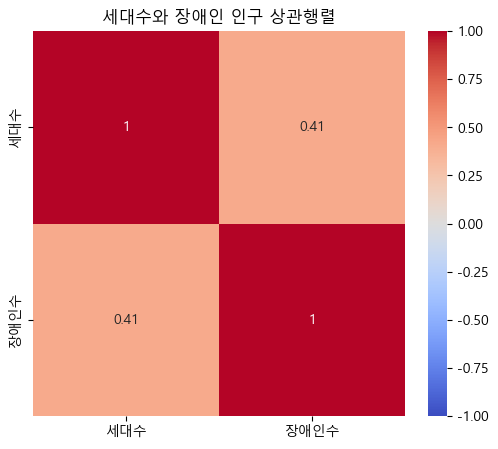

In [48]:
plt.figure(figsize = (6, 5))
sns.heatmap(merged_df[['세대수', '장애인수']].corr(), annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title('세대수와 장애인 인구 상관행렬')
plt.show()